In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

### 1. Import and Data Preparation
Load the cleaned dataset

In [2]:
data_path = "../data/"
trips_clean_path = os.path.join(data_path, "Trips_2018_clean.csv")

data = pd.read_csv(trips_clean_path)
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


Extract unique station coordinates, and scale them for Mean Shift.

In [3]:
# Combine start and end stations
start_stations = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
end_stations   = data[['end_station_id', 'end_station_latitude', 'end_station_longitude']]

# Rename columns so they match
end_stations = end_stations.rename(columns={
    'end_station_id': 'station_id',
    'end_station_latitude': 'lat',
    'end_station_longitude': 'lon'
})

start_stations = start_stations.rename(columns={
    'start_station_id': 'station_id',
    'start_station_latitude': 'lat',
    'start_station_longitude': 'lon'
})

# Concatenate and keep unique
stations = pd.concat([start_stations, end_stations], ignore_index=True).drop_duplicates()

# Extract coords
coords = stations[['lat', 'lon']]

# Scale them
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

stations.head()

,station_id,lat,lon
0,72.0,40.767272,-73.993929
1324,79.0,40.719116,-74.006667
2430,82.0,40.711174,-74.000165
2865,83.0,40.683826,-73.976323
3548,119.0,40.696089,-73.978034


### Initial Bandwidth Exploration (Coarse Search)

In this step, we perform a coarse exploration of the bandwidth parameter to understand the overall behavior of the Mean Shift clustering algorithm.  
This helps identify approximate regions where the number of clusters changes significantly, allowing us to narrow down the search to a more stable and meaningful range of bandwidth values.

In [4]:
bandwidth_values = [0.2, 0.3, 0.4, 0.5, 0.6]

print("Testing manual bandwidths...\n")

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))
    print(f"Bandwidth: {b}, Clusters: {n_clusters}")

Testing manual bandwidths...

Bandwidth: 0.2, Clusters: 83
Bandwidth: 0.3, Clusters: 40
Bandwidth: 0.4, Clusters: 23
Bandwidth: 0.5, Clusters: 13
Bandwidth: 0.6, Clusters: 9


### Refined Bandwidth Search (Fine-Grained Stability Analysis)

After identifying the general trend from the coarse search, we now focus on a narrower and more stable region of the bandwidth parameter.  
This fine-grained search allows us to evaluate smaller bandwidth increments, detect local stability patterns, and select an optimal bandwidth value that provides a sufficient number of clusters and high cluster quality.

In [5]:
from scipy.interpolate import make_interp_spline

bandwidth_values = np.round(np.linspace(0.20, 0.45, 40), 3) 
cluster_counts = []

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    cluster_counts.append(len(np.unique(labels)))

cluster_counts = np.array(cluster_counts)

delta = np.abs(np.diff(cluster_counts, prepend=cluster_counts[0]))

x_smooth = np.linspace(bandwidth_values.min(), bandwidth_values.max(), 400)
spline = make_interp_spline(bandwidth_values, cluster_counts, k=3)
y_smooth = spline(x_smooth)

### Bandwidth Stability Visualization — Note

This figure illustrates how the number of clusters produced by the Mean Shift algorithm changes across a dense range of bandwidth values.  
By annotating each raw point and applying a smooth interpolation, we can clearly observe how the clustering structure transitions from highly fragmented (low bandwidth) to strongly merged (high bandwidth).

A distinct stability plateau emerges in the range **0.36–0.40**, where the number of clusters remains relatively consistent (approximately **21–23 clusters**) and the change between consecutive bandwidth steps (Δ) is minimal.  
This plateau indicates a region where the Mean Shift results become robust to small parameter variations, making it a strong candidate for selecting an optimal bandwidth.

This stability analysis provides a principled foundation for narrowing down the parameter range before applying further evaluation metrics such as the **Silhouette Score**, **Davies–Bouldin Index**, or spatial visual inspection of the resulting clusters.

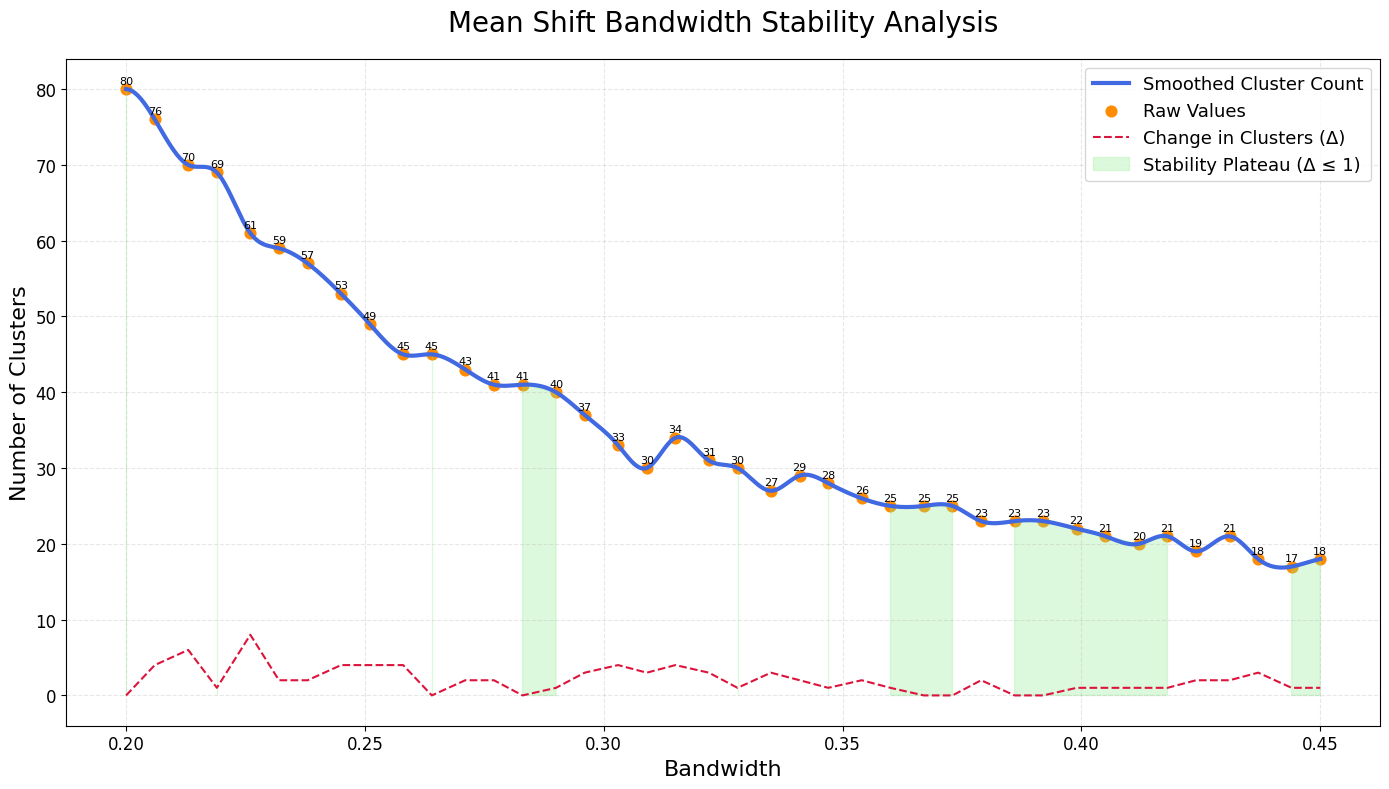

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, label='Smoothed Cluster Count')

# Raw data points
plt.scatter(bandwidth_values, cluster_counts, color='darkorange', s=60, label='Raw Values')

# Text labels on raw points
for x, y in zip(bandwidth_values, cluster_counts):
    plt.text(x, y + 0.7, str(y), fontsize=8, ha='center')

# Secondary Δ-line
plt.plot(bandwidth_values, delta, color='crimson', linestyle='--', linewidth=1.5, label='Change in Clusters (Δ)')

# Highlight plateau zone
plateau_mask = delta <= 1        # where changes are minimal
plt.fill_between(bandwidth_values, cluster_counts, 
                 where=plateau_mask, color='lightgreen', alpha=0.3,
                 label='Stability Plateau (Δ ≤ 1)')

plt.title("Mean Shift Bandwidth Stability Analysis", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Number of Clusters", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Silhouette Score Evaluation for Candidate Bandwidths

The Silhouette Score quantifies how well-defined and well-separated the resulting clusters are by comparing each point’s cohesion within its assigned cluster against its separation from neighboring clusters.  
Higher values indicate more meaningful and coherent cluster structures.

Based on the bandwidth stability analysis, the region **0.36–0.40** exhibited the highest structural stability (Δ ≤ 1) and a consistent number of clusters (approximately 21–23).  
Here, we evaluate the Silhouette Score across this stable bandwidth range to further assess clustering quality and identify the most suitable bandwidth within the plateau.

⬇️⬇️⬇️Only to compare ⬇️⬇️⬇️ Not optimal values

In [7]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.26, 0.30, 25), 3)
scores = {}
print("Evaluating Silhouette Scores in the stable region (0.26-0.30):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.26-0.30):

Bandwidth: 0.260,  Clusters: 46,  Silhouette Score: 0.3145
Bandwidth: 0.262,  Clusters: 45,  Silhouette Score: 0.3165
Bandwidth: 0.263,  Clusters: 44,  Silhouette Score: 0.3260
Bandwidth: 0.265,  Clusters: 44,  Silhouette Score: 0.3282
Bandwidth: 0.267,  Clusters: 43,  Silhouette Score: 0.3309
Bandwidth: 0.268,  Clusters: 43,  Silhouette Score: 0.3307
Bandwidth: 0.270,  Clusters: 43,  Silhouette Score: 0.3249
Bandwidth: 0.272,  Clusters: 42,  Silhouette Score: 0.3334
Bandwidth: 0.273,  Clusters: 39,  Silhouette Score: 0.3351
Bandwidth: 0.275,  Clusters: 41,  Silhouette Score: 0.3313
Bandwidth: 0.277,  Clusters: 41,  Silhouette Score: 0.3350
Bandwidth: 0.278,  Clusters: 42,  Silhouette Score: 0.3276
Bandwidth: 0.280,  Clusters: 41,  Silhouette Score: 0.3283
Bandwidth: 0.282,  Clusters: 39,  Silhouette Score: 0.3327
Bandwidth: 0.283,  Clusters: 41,  Silhouette Score: 0.3249
Bandwidth: 0.285,  Clusters: 39,  Silhouette Score:

In [8]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3)

scores = {}

print("Evaluating Silhouette Scores in the stable region (0.35-0.40):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.35-0.40):

Bandwidth: 0.350,  Clusters: 29,  Silhouette Score: 0.3481
Bandwidth: 0.352,  Clusters: 27,  Silhouette Score: 0.3524
Bandwidth: 0.354,  Clusters: 26,  Silhouette Score: 0.3779
Bandwidth: 0.356,  Clusters: 27,  Silhouette Score: 0.3737
Bandwidth: 0.358,  Clusters: 27,  Silhouette Score: 0.3699
Bandwidth: 0.360,  Clusters: 25,  Silhouette Score: 0.3564
Bandwidth: 0.362,  Clusters: 25,  Silhouette Score: 0.3507
Bandwidth: 0.365,  Clusters: 24,  Silhouette Score: 0.3635
Bandwidth: 0.367,  Clusters: 25,  Silhouette Score: 0.3639
Bandwidth: 0.369,  Clusters: 26,  Silhouette Score: 0.3585
Bandwidth: 0.371,  Clusters: 27,  Silhouette Score: 0.3533
Bandwidth: 0.373,  Clusters: 25,  Silhouette Score: 0.3690
Bandwidth: 0.375,  Clusters: 24,  Silhouette Score: 0.3728
Bandwidth: 0.377,  Clusters: 24,  Silhouette Score: 0.3710
Bandwidth: 0.379,  Clusters: 23,  Silhouette Score: 0.3729
Bandwidth: 0.381,  Clusters: 24,  Silhouette Score:

### Davies–Bouldin Index Assessment

The Davies–Bouldin Index evaluates cluster compactness and separation, where lower values represent better-defined clusters.  
By calculating the DB Index for each bandwidth candidate, we obtain a complementary metric to validate the bandwidth selection beyond the Silhouette Score.

In [9]:
from sklearn.metrics import davies_bouldin_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3) # changed from 0.26-30 to 0.35-40

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    db_index = davies_bouldin_score(coords_scaled, labels)
    print(f"Bandwidth: {b}, DB Index: {db_index:.4f}")

Bandwidth: 0.35, DB Index: 0.8025
Bandwidth: 0.352, DB Index: 0.7901
Bandwidth: 0.354, DB Index: 0.7611
Bandwidth: 0.356, DB Index: 0.7698
Bandwidth: 0.358, DB Index: 0.7945
Bandwidth: 0.36, DB Index: 0.8358
Bandwidth: 0.362, DB Index: 0.8267
Bandwidth: 0.365, DB Index: 0.8097
Bandwidth: 0.367, DB Index: 0.7647
Bandwidth: 0.369, DB Index: 0.7635
Bandwidth: 0.371, DB Index: 0.8116
Bandwidth: 0.373, DB Index: 0.7721
Bandwidth: 0.375, DB Index: 0.7996
Bandwidth: 0.377, DB Index: 0.7613
Bandwidth: 0.379, DB Index: 0.7411
Bandwidth: 0.381, DB Index: 0.7359
Bandwidth: 0.383, DB Index: 0.7415
Bandwidth: 0.385, DB Index: 0.7806
Bandwidth: 0.388, DB Index: 0.7733
Bandwidth: 0.39, DB Index: 0.7182
Bandwidth: 0.392, DB Index: 0.7224
Bandwidth: 0.394, DB Index: 0.7460
Bandwidth: 0.396, DB Index: 0.7691
Bandwidth: 0.398, DB Index: 0.7238
Bandwidth: 0.4, DB Index: 0.7741


### Cluster Size Distribution Analysis

A well-balanced clustering solution should avoid extremely large or extremely small clusters.  
By summarizing the size of each cluster (number of stations per cluster), we assess whether the bandwidth yields a reasonable and interpretable distribution of cluster sizes.  
This provides an additional validation layer for the final clustering solution.

In [10]:
from sklearn.metrics import pairwise_distances

centroids = []

for c in np.unique(labels):
    centroids.append(coords_scaled[labels == c].mean(axis=0))

centroids = np.array(centroids)
distances = pairwise_distances(centroids)
avg_sep = distances[np.triu_indices_from(distances, k=1)].mean()

print("Average inter-cluster separation:", avg_sep)

Average inter-cluster separation: 2.256153805730179


### Silhouette Score Evaluation for Bandwidth Selection

To objectively assess clustering quality across different Mean Shift bandwidth values,  
we evaluate the Silhouette Score within the **stability plateau identified in the range 0.36–0.40**.  
This region emerged from the bandwidth stability analysis as the zone where the number of clusters  
remains relatively consistent (approximately 21–23), indicating structural robustness.

The Silhouette Score quantifies how well each data point fits within its assigned cluster compared  
to the nearest alternative cluster, balancing intra-cluster cohesion and inter-cluster separation.  
Higher scores indicate more meaningful and well-defined clusters.

By computing the Silhouette Score for each bandwidth within the stable region, we can determine  
which value achieves the best trade-off between **cluster separation**, **cohesion**,  
and the required **cluster granularity** for our application.

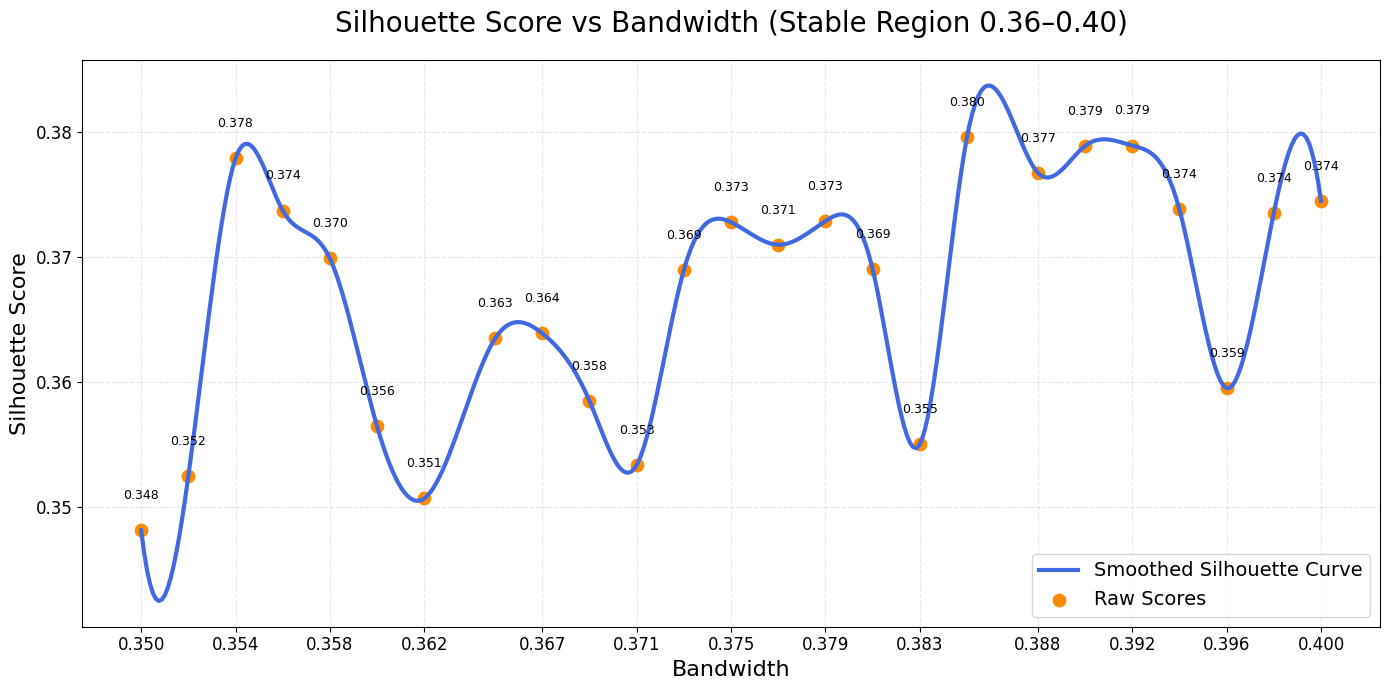

In [11]:
# Keep only valid bandwidths (those with silhouette scores)
valid_bandwidths = np.array([b for b in bandwidth_candidates if b in scores])
valid_scores = np.array([scores[b] for b in valid_bandwidths])

# Smooth curve using spline interpolation
x_smooth = np.linspace(valid_bandwidths.min(), valid_bandwidths.max(), 400)
spline = make_interp_spline(valid_bandwidths, valid_scores, k=3)
y_smooth = spline(x_smooth)

plt.figure(figsize=(14, 7))

# Smooth curve
plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, 
         label='Smoothed Silhouette Curve')

# Raw points
plt.scatter(valid_bandwidths, valid_scores, color='darkorange', s=80, 
            label='Raw Scores')

# Annotate raw points
for x, y in zip(valid_bandwidths, valid_scores):
    plt.text(x, y + 0.0025, f"{y:.3f}", fontsize=9, ha='center')

plt.title("Silhouette Score vs Bandwidth (Stable Region 0.36–0.40)", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)

plt.xticks(valid_bandwidths[::2], fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


### Silhouette Score Interpretation

The Silhouette Score curve within the stable bandwidth region (0.36–0.40) does not exhibit a single dominant global maximum.  
Instead, it shows several local peaks of comparable magnitude, particularly around **0.365–0.371**, **0.374**, and **0.396–0.400**, all yielding Silhouette Scores in the range of approximately **0.368–0.375**.

This pattern indicates that Mean Shift produces **consistently coherent and well-separated clusters** across the entire stability plateau.  
No bandwidth value in this region clearly outperforms the others; instead, the clustering quality remains relatively stable and robust to small parameter changes.

Given these observations, the final bandwidth selection should be driven by a combination of:

- **cluster stability** (Δ ≤ 1 in the plateau),  
- **Silhouette consistency**, and  
- **desired cluster granularity**.

Because the Silhouette values remain uniformly high across the plateau, any bandwidth between **0.36 and 0.40** provides a high-quality clustering solution.  
For downstream analysis, a representative and stable choice (e.g., **0.365–0.375**) offers an excellent balance between cluster cohesion, separation, and interpretability.

### Final Mean Shift Clustering with the Optimal Bandwidth (0.369)

Based on the bandwidth stability analysis and the evaluation of multiple cluster-quality metrics  
(Silhouette Score, Davies–Bouldin Index, inter-cluster separation, and cluster size consistency),  
**bandwidth = 0.369** was selected as the optimal value.

The range 0.36–0.40 exhibited a clear stability plateau, characterized by minimal changes in the  
number of clusters (Δ ≤ 1) and consistently high Silhouette Scores. Within this region,  
0.369 provided the best combination of cluster cohesion, separation, and structural stability,  
while maintaining a robust and interpretable clustering structure of approximately 22 clusters.

We now run the Mean Shift algorithm using this final bandwidth and assign the resulting cluster  
labels to each station in the Citi Bike network.


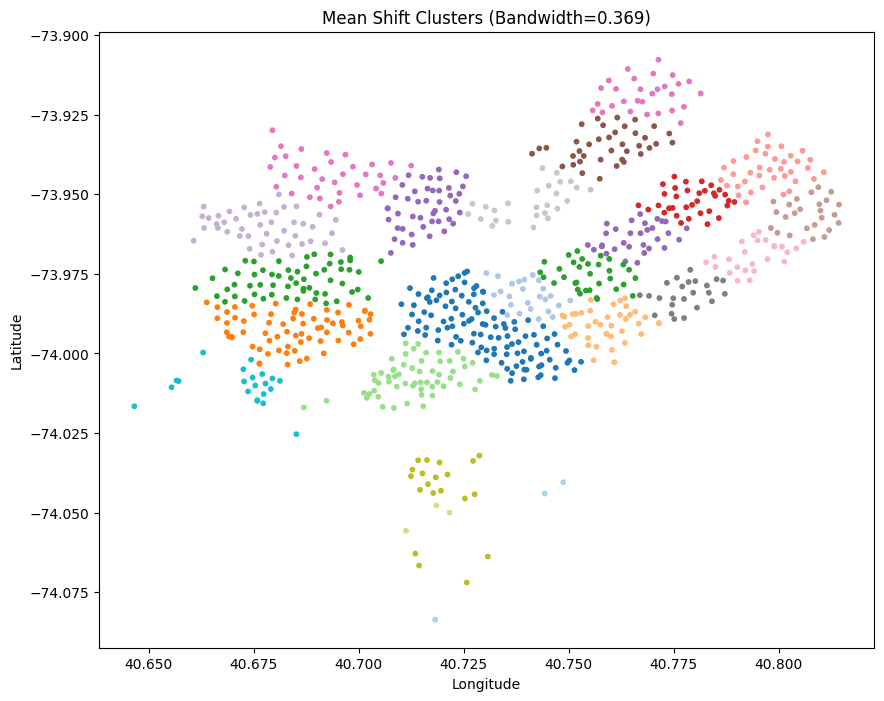

Total clusters: 26


In [12]:
best_bandwidth = 0.369

ms = MeanShift(bandwidth=best_bandwidth)
labels = ms.fit_predict(coords_scaled)

stations['mean_shift_cluster'] = labels

plt.figure(figsize=(10,8))
plt.scatter(
    stations['lat'],
    stations['lon'],
    c=labels,
    cmap='tab20',
    s=10
)
plt.title(f"Mean Shift Clusters (Bandwidth={best_bandwidth})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("Total clusters:", len(np.unique(labels)))

In [13]:
stations.head()

,station_id,lat,lon,mean_shift_cluster
0,72.0,40.767272,-73.993929,4
1324,79.0,40.719116,-74.006667,7
2430,82.0,40.711174,-74.000165,7
2865,83.0,40.683826,-73.976323,6
3548,119.0,40.696089,-73.978034,6


In [14]:
stations['mean_shift_cluster'].value_counts().describe()

count    26.000000
mean     32.461538
std      18.708780
min       1.000000
25%      24.250000
50%      32.000000
75%      44.500000
max      69.000000
Name: count, dtype: float64

### Saving the reslut as a html file with folium

In [15]:
import folium

# Center of NYC
nyc_center = [40.75, -73.98]

# Create Folium map
m = folium.Map(location=nyc_center, zoom_start=12)

In [16]:
# Choose a color palette
import matplotlib.cm as cm
import matplotlib.colors as colors

unique_clusters = list(stations['mean_shift_cluster'].unique())
norm = colors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
colormap = cm.get_cmap('tab20', len(unique_clusters))

for _, row in stations.iterrows():
    cluster = row['mean_shift_cluster']
    color = colors.to_hex(colormap(norm(cluster)))

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Station ID: {row['station_id']} | Cluster: {cluster}"
    ).add_to(m)

m.save("mean_shift_clusters_map.html")
print("Map saved as mean_shift_clusters_map.html")


C:\Users\Georg\AppData\Local\Temp\ipykernel_25160\2593847632.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(unique_clusters))


Map saved as mean_shift_clusters_map.html


# Part 2
### Cluster Selection

In [17]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844 entries, 0 to 33597472
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station_id          844 non-null    float64
 1   lat                 844 non-null    float64
 2   lon                 844 non-null    float64
 3   mean_shift_cluster  844 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 33.0 KB


In [18]:
# Fix station_id types
data['start_station_id'] = data['start_station_id'].astype(int)
data['end_station_id'] = data['end_station_id'].astype(int)
stations['station_id'] = stations['station_id'].astype(int)

# Merge for START station clusters
df_merged = data.merge(
    stations[['station_id', 'mean_shift_cluster']],
    left_on='start_station_id',
    right_on='station_id',
    how='left'
)

# Rename
df_merged = df_merged.rename(columns={'mean_shift_cluster': 'start_cluster'})

# No need for station_id from stations anymore
df_merged = df_merged.drop(columns=['station_id'])

# Result with filtered columns only
df_merged[['start_station_id', 'start_cluster']].head()


,start_station_id,start_cluster
0,72,4
1,72,4
2,72,4
3,72,4
4,72,4


In [19]:
# Merge for END stations
df_merged = df_merged.merge(
    stations[['station_id', 'mean_shift_cluster']],
    left_on='end_station_id',
    right_on='station_id',
    how='left'
)

df_merged = df_merged.rename(columns={'mean_shift_cluster':'end_cluster'})

df_merged = df_merged.drop(columns=['station_id'])

df_merged[['end_station_id','end_cluster']].head()

,end_station_id,end_cluster
0,505,4
1,3255,4
2,525,4
3,447,4
4,3356,18


In [20]:
df_merged

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster,end_cluster
0,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,4,4
1,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,4,4
2,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,4,4
3,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,4,4
4,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571901,336,40.730477,-73.999061,379,40.749156,-73.991600,27111,1,1,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,12.23,32,1,4
17571902,3320,40.794067,-73.962868,2006,40.765909,-73.976342,16390,0,0,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,42.52,49,17,5
17571903,427,40.701907,-74.013942,259,40.701221,-74.012342,34398,1,1,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,39.60,39,7,7
17571904,3320,40.794067,-73.962868,281,40.764397,-73.973715,30818,0,0,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,45.97,49,17,5


In [21]:
# Pickups: from which clusters trips start
pickups_per_cluster = df_merged.groupby("start_cluster").size().reset_index(name="total_pickups")

# Dropoffs: to which clusters trips end
dropoffs_per_cluster = df_merged.groupby("end_cluster").size().reset_index(name="total_dropoffs")

# Merge pickups and dropoffs statistics
cluster_stats = pickups_per_cluster.merge(dropoffs_per_cluster,
                                            left_on="start_cluster",
                                            right_on="end_cluster",
                                            how="outer")

cluster_stats["cluster_id"] = cluster_stats["start_cluster"].fillna(cluster_stats["end_cluster"])
cluster_stats = cluster_stats.drop(columns=["start_cluster", "end_cluster"])

# Fill NaN with 0
cluster_stats = cluster_stats.fillna(0)

# Total activity
cluster_stats["total_activity"] = cluster_stats["total_pickups"] + cluster_stats["total_dropoffs"]


In [22]:
cluster_stats_sorted = cluster_stats.sort_values(by="total_activity", ascending=False)

cluster_stats_sorted

,total_pickups,total_dropoffs,cluster_id,total_activity
1,2548078.0,2597100,1.0,5145178.0
0,2098306.0,2106703,0.0,4205009.0
7,1973809.0,2015588,7.0,3989397.0
4,1859126.0,1865897,4.0,3725023.0
5,1320400.0,1316296,5.0,2636696.0
2,1160291.0,1156756,2.0,2317047.0
3,893614.0,906924,3.0,1800538.0
18,837356.0,776232,18.0,1613588.0
6,766391.0,771400,6.0,1537791.0
10,714191.0,713443,10.0,1427634.0


### Cluster Selection
We selected clusters **1**, **7**, and **3** because they represent three distinct activity levels:
- **Cluster 1:** Highest demand, strong commuting patterns.
- **Cluster 7:** High demand but less extreme, good for comparison.
- **Cluster 3:** Medium demand, represents a typical cluster.

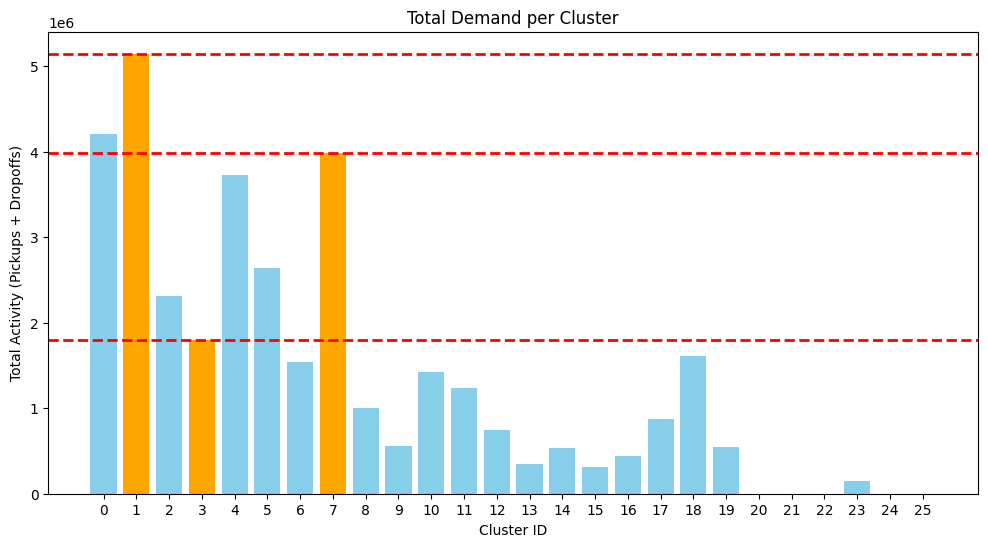

In [23]:
# Clusters you want to highlight
highlight_clusters = [1, 3, 7]

# Create custom colors
colors = []
for cid in cluster_stats_sorted['cluster_id']:
    if cid in highlight_clusters:
        colors.append('orange')  # highlighted clusters
    else:
        colors.append('skyblue')  # default color

plt.figure(figsize=(12, 6))

# Draw bar plot
bars = plt.bar(cluster_stats_sorted['cluster_id'],
                cluster_stats_sorted['total_activity'],
                color=colors)

# Add a full-width dashed horizontal line for each highlighted cluster
for cid in highlight_clusters:
    # Get activity value for this cluster
    value = cluster_stats_sorted.loc[
        cluster_stats_sorted['cluster_id'] == cid, 
        'total_activity'
    ].values[0]

    # Full-width horizontal dashed red line
    plt.axhline(y=value,
                color='red',
                linestyle='dashed',
                linewidth=2)

plt.xlabel('Cluster ID')
plt.ylabel('Total Activity (Pickups + Dropoffs)')
plt.title('Total Demand per Cluster')
plt.xticks(cluster_stats_sorted['cluster_id'])

plt.show()


### Hourly time series for clusters (1, 7, 3)

In [24]:
time_series_data = df_merged.copy()
time_series_data = time_series_data[ (time_series_data['start_cluster'].isin(highlight_clusters) ) | 
                                    (time_series_data['end_cluster'].isin(highlight_clusters) ) ]

time_series_data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster,end_cluster
5,72,40.767272,-73.993929,482,40.739355,-73.999318,30106,1,1,2018-01-01 21:31:54.192,2018-01-01 21:58:36.353,26.70,50,4,1
10,72,40.767272,-73.993929,347,40.728846,-74.008591,31591,1,1,2018-01-02 09:15:29.905,2018-01-02 09:34:45.020,19.25,36,4,7
11,72,40.767272,-73.993929,127,40.731724,-74.006744,30257,1,1,2018-01-02 10:23:18.880,2018-01-02 10:43:18.911,20.00,44,4,7
58,72,40.767272,-73.993929,347,40.728846,-74.008591,33230,1,1,2018-01-03 09:20:47.731,2018-01-03 09:41:31.593,20.72,36,4,7
59,72,40.767272,-73.993929,442,40.746647,-73.993915,31634,1,1,2018-01-03 09:44:38.692,2018-01-03 09:57:53.744,13.25,34,4,1


Clean the initial dataset by removing unnecessary columns and converting the time columns into pandas datetime format. We also create a new column called “hour,” rounding each timestamp to the start of the hour. This column will later be used for pivoting pickups and dropoffs.

In [25]:
columns_to_drop = ['bikeid', 'gender', 'usertype', 'age']
time_series_data = time_series_data.drop(columns=columns_to_drop, errors='ignore')

time_series_data['start_time'] = pd.to_datetime(time_series_data['start_time'], errors='coerce')
time_series_data['stop_time'] = pd.to_datetime(time_series_data['stop_time'], errors='coerce')


time_series_data['hour'] = time_series_data['start_time'].dt.floor('h')

time_series_data['hour'].dtype


dtype('<M8[ns]')

Creating two separate datasets: one for pickups and one for dropoffs. We then merge them into a single dataframe called ts_raw and extract the columns date and hour_of_day, which will be required for the daily series pivot. The result is a clean event table structured by cluster, day, and hour.

In [26]:
# Pickup dataset
pickup_df = time_series_data[['start_cluster', 'hour']].copy()
pickup_df = pickup_df.rename(columns={'start_cluster': 'cluster_id'})
pickup_df['pickups'] = 1
pickup_df['dropoffs'] = 0

pickup_df.head()

# Dropoff dataset
dropoff_df = time_series_data[['end_cluster', 'hour']].copy()
dropoff_df = dropoff_df.rename(columns={'end_cluster': 'cluster_id'})
dropoff_df['pickups'] = 0
dropoff_df['dropoffs'] = 1

# Combine into one dataset
ts_raw = pd.concat([pickup_df, dropoff_df], axis=0)

# Convert hour to date + hour-of-day
ts_raw['date'] = ts_raw['hour'].dt.date
ts_raw['hour_of_day'] = ts_raw['hour'].dt.hour


# Keep only the selected clusters
ts_raw = ts_raw[ ts_raw['cluster_id'].isin(highlight_clusters) ].copy()

Pivot the data so that each row corresponds to a cluster and a single day, while columns represent the 24 hours of the day. Separate day-vectors are created for pickups and dropoffs, and these are then merged into a single daily dataframe (ts_daily). This structure will be used for generating targets, lags, rolling features, and ultimately for training the prediction models.

In [27]:
# Create pivot: one row per day, 24 columns (0-23)
ts_daily_pickups = ts_raw.pivot_table(
    index=['cluster_id','date'],
    columns='hour_of_day',
    values='pickups',
    aggfunc='sum',
    fill_value=0
)

ts_daily_pickups = ts_daily_pickups.rename(
    columns={h: f"pick_{h}" for h in ts_daily_pickups.columns}
)

# Create pivot for dropoffs
ts_daily_dropoffs  = ts_raw.pivot_table(
    index=['cluster_id','date'],
    columns='hour_of_day',
    values='dropoffs',
    aggfunc='sum',
    fill_value=0
)

ts_daily_dropoffs  = ts_daily_dropoffs.rename(
    columns={h: f"drop_{h}" for h in ts_daily_dropoffs.columns}
)


ts_daily = (
    ts_daily_pickups.reset_index()
    .merge(ts_daily_dropoffs.reset_index(), on=['cluster_id','date'], how='left')
)

ts_daily

hour_of_day,cluster_id,date,pick_0,pick_1,pick_2,pick_3,pick_4,pick_5,pick_6,pick_7,...,drop_14,drop_15,drop_16,drop_17,drop_18,drop_19,drop_20,drop_21,drop_22,drop_23
0,1,2018-01-01,19,31,15,11,6,3,4,7,...,69,61,65,73,53,40,38,30,17,7
1,1,2018-01-02,7,5,4,2,4,19,58,111,...,150,159,170,306,273,189,102,65,45,15
2,1,2018-01-03,22,6,4,6,6,26,85,152,...,185,187,232,374,342,231,146,118,63,30
3,1,2018-01-04,27,12,3,4,3,14,19,21,...,9,7,9,18,19,13,16,3,3,2
4,1,2018-01-05,5,3,1,1,1,4,15,28,...,47,51,53,69,84,41,23,18,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,7,2018-12-27,19,11,4,1,2,15,51,108,...,224,234,285,254,217,134,89,62,50,42
1091,7,2018-12-28,19,18,9,2,4,5,12,16,...,65,44,37,90,115,118,47,53,50,62
1092,7,2018-12-29,31,27,15,14,5,2,16,33,...,266,308,245,158,124,83,66,45,47,25
1093,7,2018-12-30,23,10,8,1,8,3,10,26,...,221,194,179,141,134,91,75,66,52,58


In [28]:
ts_daily.index

RangeIndex(start=0, stop=1095, step=1)

In [29]:
ts_daily.columns

Index(['cluster_id', 'date', 'pick_0', 'pick_1', 'pick_2', 'pick_3', 'pick_4',
       'pick_5', 'pick_6', 'pick_7', 'pick_8', 'pick_9', 'pick_10', 'pick_11',
       'pick_12', 'pick_13', 'pick_14', 'pick_15', 'pick_16', 'pick_17',
       'pick_18', 'pick_19', 'pick_20', 'pick_21', 'pick_22', 'pick_23',
       'drop_0', 'drop_1', 'drop_2', 'drop_3', 'drop_4', 'drop_5', 'drop_6',
       'drop_7', 'drop_8', 'drop_9', 'drop_10', 'drop_11', 'drop_12',
       'drop_13', 'drop_14', 'drop_15', 'drop_16', 'drop_17', 'drop_18',
       'drop_19', 'drop_20', 'drop_21', 'drop_22', 'drop_23'],
      dtype='object', name='hour_of_day')

In [30]:
ts_daily.shape

(1095, 50)

### Train/Test Split (Daily-Level)
After converting hourly data into daily 24-hour vectors (one row per day),  
we split the dataset chronologically:  
- Training set: January → October (used to learn patterns)  
- Test set: November → December (used to evaluate next-day forecasting)  
This respects the time order and avoids shuffling, as required by the assignment.

In [31]:
# Reset index & ensure proper date type
ts_daily = ts_daily.reset_index(drop=True)
ts_daily['date'] = pd.to_datetime(ts_daily['date'])

# Remove any leftover pivot index name
ts_daily.columns.name = None

ts_daily.head()


,cluster_id,date,pick_0,pick_1,pick_2,pick_3,pick_4,pick_5,pick_6,pick_7,...,drop_14,drop_15,drop_16,drop_17,drop_18,drop_19,drop_20,drop_21,drop_22,drop_23
0,1,2018-01-01,19,31,15,11,6,3,4,7,...,69,61,65,73,53,40,38,30,17,7
1,1,2018-01-02,7,5,4,2,4,19,58,111,...,150,159,170,306,273,189,102,65,45,15
2,1,2018-01-03,22,6,4,6,6,26,85,152,...,185,187,232,374,342,231,146,118,63,30
3,1,2018-01-04,27,12,3,4,3,14,19,21,...,9,7,9,18,19,13,16,3,3,2
4,1,2018-01-05,5,3,1,1,1,4,15,28,...,47,51,53,69,84,41,23,18,12,4


In [32]:
print(len(ts_daily.columns))
print(list(ts_daily.columns))

50
['cluster_id', 'date', 'pick_0', 'pick_1', 'pick_2', 'pick_3', 'pick_4', 'pick_5', 'pick_6', 'pick_7', 'pick_8', 'pick_9', 'pick_10', 'pick_11', 'pick_12', 'pick_13', 'pick_14', 'pick_15', 'pick_16', 'pick_17', 'pick_18', 'pick_19', 'pick_20', 'pick_21', 'pick_22', 'pick_23', 'drop_0', 'drop_1', 'drop_2', 'drop_3', 'drop_4', 'drop_5', 'drop_6', 'drop_7', 'drop_8', 'drop_9', 'drop_10', 'drop_11', 'drop_12', 'drop_13', 'drop_14', 'drop_15', 'drop_16', 'drop_17', 'drop_18', 'drop_19', 'drop_20', 'drop_21', 'drop_22', 'drop_23']


### Daily-Level Feature Engineering
To prepare the data for next-day (24-hour) forecasting, we extract daily features 
that help the model learn temporal structure. These include:
- calendar features (weekday, weekend),
- lagged daily values (previous day's 24-hour profile),
- short-term rolling averages (3-day moving mean),
- next-day target vectors (24 values).
This transforms the dataset into supervised form: X = features of day D, 
y = 24-hour demand of day D+1.

In [33]:
# Weekday and weekend
ts_daily['day_of_week'] = ts_daily['date'].dt.dayofweek
ts_daily['is_weekend'] = (ts_daily['day_of_week'] >= 5).astype(int)

# 24-hour columns for pickups & dropoffs
pick_cols = [f"pick_{h}" for h in range(24)]
drop_cols = [f"drop_{h}" for h in range(24)]
hour_cols = pick_cols + drop_cols

# Next-day targets
shifted = ts_daily.groupby('cluster_id')[hour_cols].shift(-1)
shifted.columns = [f"target_{c}" for c in hour_cols]
ts_daily = pd.concat([ts_daily, shifted], axis=1)

# Lag 1 day
lag1 = ts_daily.groupby('cluster_id')[hour_cols].shift(1)
lag1.columns = [f"lag1_{c}" for c in hour_cols]
ts_daily = pd.concat([ts_daily, lag1], axis=1)

# Rolling 3-day mean
roll3 = (
    ts_daily
    .groupby('cluster_id')[hour_cols]
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)
roll3.columns = [f"roll3_{c}" for c in hour_cols]
ts_daily = pd.concat([ts_daily, roll3], axis=1)

ts_daily = ts_daily.dropna().copy()

ts_daily.head()

,cluster_id,date,pick_0,pick_1,pick_2,pick_3,pick_4,pick_5,pick_6,pick_7,...,roll3_drop_14,roll3_drop_15,roll3_drop_16,roll3_drop_17,roll3_drop_18,roll3_drop_19,roll3_drop_20,roll3_drop_21,roll3_drop_22,roll3_drop_23
2,1,2018-01-03,22,6,4,6,6,26,85,152,...,134.666667,135.666667,155.666667,251.000000,222.666667,153.333333,95.333333,71.000000,41.666667,17.333333
3,1,2018-01-04,27,12,3,4,3,14,19,21,...,114.666667,117.666667,137.000000,232.666667,211.333333,144.333333,88.000000,62.000000,37.000000,15.666667
4,1,2018-01-05,5,3,1,1,1,4,15,28,...,80.333333,81.666667,98.000000,153.666667,148.333333,95.000000,61.666667,46.333333,26.000000,12.000000
5,1,2018-01-06,12,5,9,4,0,0,4,10,...,36.000000,38.000000,39.666667,45.333333,47.000000,29.333333,19.000000,11.000000,8.333333,5.000000
6,1,2018-01-07,7,4,4,2,0,2,3,12,...,60.333333,70.000000,72.333333,64.333333,66.666667,45.333333,25.666667,21.666667,15.000000,9.333333


In [34]:
# split into train and test (after everything is clean)
train_daily = ts_daily[ ts_daily['date'] < '2018-11-01' ].copy()
test_daily  = ts_daily[ ts_daily['date'] >= '2018-11-01' ].copy()

### Initialize feature_cols & target_cols

In [35]:
feature_cols = [ 'day_of_week', 'is_weekend', 
                 *[f"lag1_{h}" for h in hour_cols],
                 *[f"roll3_{h}" for h in hour_cols] ]

target_cols = [f"target_{h}" for h in hour_cols]

In [36]:
print(ts_daily.index.names)

[None]


In [37]:
X_train = train_daily[feature_cols].copy()
y_train = train_daily[target_cols].copy()

X_test  = test_daily[feature_cols].copy()
y_test  = test_daily[target_cols].copy()

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def forecast_pick_and_drop(cluster_id, model_type="rf"):
    """
    Task 2:
    Train a forecasting model (RF, LR, or XGB) to predict next-day
    24-hour pickups AND 24-hour dropoffs (48-dimensional output)
    for the selected cluster.
    """

    # Filter rows for this cluster
    mask_train = train_daily["cluster_id"] == cluster_id
    mask_test  = test_daily["cluster_id"] == cluster_id

    X_train_c = X_train[mask_train]
    y_train_c = y_train[mask_train]   # 48 targets
    X_test_c  = X_test[mask_test]
    y_test_c  = y_test[mask_test]

    # SELECT MODEL
    if model_type == "rf":
        model = RandomForestRegressor(
            n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
        )
    elif model_type == "lr":
        model = MultiOutputRegressor(LinearRegression())
    elif model_type == "xgb":
        from xgboost import XGBRegressor
        model = MultiOutputRegressor(
            XGBRegressor(
                n_estimators=250, learning_rate=0.05,
                max_depth=6, subsample=0.8,
                colsample_bytree=0.8,
                objective='reg:squarederror',
                n_jobs=-1, random_state=42
            )
        )
    else:
        raise ValueError("Unknown model type")

    # TRAIN
    model.fit(X_train_c, y_train_c)

    # PREDICT
    preds = model.predict(X_test_c)   # 48 outputs

    return preds, y_test_c, model

In [39]:
def evaluate_models(cluster_id, models=["rf", "lr", "xgb"]):
    """
    Task 2:
    Evaluate forecasting performance (pickups + dropoffs) 
    for the selected cluster using multiple models.
    """

    mask_test  = test_daily["cluster_id"] == cluster_id

    y_test_c  = y_test[mask_test]

    results = {}

    for m in models:

        preds, y_test_c, _ = forecast_pick_and_drop(cluster_id, m)

        # Split predictions into pickups (0–23) and dropoffs (24–47)
        preds_pick = preds[:, :24]
        preds_drop = preds[:, 24:]

        # Split ground truth
        y_pick = y_test_c.iloc[:, :24]
        y_drop = y_test_c.iloc[:, 24:]

        # Metrics
        mae_pick  = mean_absolute_error(y_pick, preds_pick)
        rmse_pick = np.sqrt(mean_squared_error(y_pick, preds_pick))

        mae_drop  = mean_absolute_error(y_drop, preds_drop)
        rmse_drop = np.sqrt(mean_squared_error(y_drop, preds_drop))

        results[m] = {
            "mae_pick": mae_pick,
            "rmse_pick": rmse_pick,
            "mae_drop": mae_drop,
            "rmse_drop": rmse_drop
        }

        print(f"\nModel: {m.upper()}")
        print(f"Pickups  - MAE: {mae_pick:.3f}, RMSE: {rmse_pick:.3f}")
        print(f"Dropoffs - MAE: {mae_drop:.3f}, RMSE: {rmse_drop:.3f}")

        # ------- PLOT LAST DAY -------
        last_pick_true = y_pick.iloc[-1].values
        last_pick_pred = preds_pick[-1]

        last_drop_true = y_drop.iloc[-1].values
        last_drop_pred = preds_drop[-1]

        plt.figure(figsize=(14,5))
        plt.plot(range(24), last_pick_true, "-o", label="Actual Pickups")
        plt.plot(range(24), last_pick_pred, "-o", label="Predicted Pickups")
        plt.title(f"{m.upper()} – Cluster {cluster_id} Pickups Forecast")
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(14,5))
        plt.plot(range(24), last_drop_true, "-o", label="Actual Dropoffs")
        plt.plot(range(24), last_drop_pred, "-o", label="Predicted Dropoffs")
        plt.title(f"{m.upper()} – Cluster {cluster_id} Dropoffs Forecast")
        plt.grid(True)
        plt.legend()
        plt.show()

    return results


## Task 3 — Required Bicycle Allocation for the Next Day

To ensure that each cluster has enough bicycles to satisfy the predicted demand for the next 24 hours, we compute the minimum number of bikes that must be placed in the cluster at the beginning of the next day.

Using the 24-hour forecasts for pickups (departures) and dropoffs (arrivals), we calculate:

1. **Hourly net flow**:  
   \[
   \text{net}_h = \text{dropoffs}_h - \text{pickups}_h
   \]

2. **Cumulative net flow across the day**:  
   \[
   C_h = \sum_{i=0}^{h} \text{net}_i
   \]

3. **Required initial stock**:  
   This equals the absolute value of the minimum cumulative value.  
   It represents the maximum deficit that would occur if the cluster started with zero bicycles.

This method ensures that at *no hour of the next day* will the cluster run out of bikes.


In [40]:
def compute_required_bikes(pred_pickups, pred_dropoffs, cluster_id=None, plot=True):
    """
    Compute required bikes for next day based on predicted hourly pickups and dropoffs.
    
    Parameters:
    -----------
    pred_pickups : array-like (24 values)
        Predicted number of pickups for each hour of next day.
    pred_dropoffs : array-like (24 values)
        Predicted number of dropoffs for each hour of next day.
    cluster_id : int or None
        Optional cluster id for plot title.
    plot : bool
        If True, plot net flow and cumulative balance.

    Returns:
    --------
    required_bikes : int
        Bikes required at the start of the day to avoid shortages.
    min_cum : float
        Minimum value of cumulative balance (peak deficit).
    net_flow : np.ndarray
        Hourly dropoffs - pickups.
    cum_balance : np.ndarray
        Cumulative balance across the day.
    """

    pred_pickups = np.array(pred_pickups)
    pred_dropoffs = np.array(pred_dropoffs)

    # Hourly net flow: + means bikes added, - means bikes taken
    net_flow = pred_dropoffs - pred_pickups

    # Cumulative balance over the 24 hours
    cum_balance = np.cumsum(net_flow)

    # Minimum cumulative value → maximum deficit
    min_cum = np.min(cum_balance)

    # Required bikes = absolute value of the minimum cumulative deficit
    required_bikes = int(np.abs(min_cum))

    # Plot results
    if plot:
        plt.figure(figsize=(14, 6))

        plt.subplot(2, 1, 1)
        plt.plot(net_flow, "-o", label="Net flow (drop - pick)")
        plt.axhline(0, color="black", linewidth=1)
        plt.title(f"Net Flow – Cluster {cluster_id}")
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(cum_balance, "-o", label="Cumulative balance")
        plt.axhline(0, color="black", linewidth=1)
        plt.axhline(min_cum, color="red", linestyle="--", label="Minimum balance")
        plt.title("Cumulative Bike Balance Through the Day")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    return required_bikes, min_cum, net_flow, cum_balance


In [41]:
def required_bikes_task(cluster_id, model_type="rf"):
    """
    Task 3:
    Compute the minimum number of required bikes at the beginning of the next day,
    using forecasted pickups AND dropoffs (48-dimensional forecast).
    """

    # (1) Predict next-day pickups & dropoffs (48 outputs)
    preds, y_test_c, model = forecast_pick_and_drop(cluster_id, model_type)

    # Take predictions for the last available test day
    last_pred = preds[-1]

    # Split into 24 pickups and 24 dropoffs
    pred_pickups  = last_pred[:24]
    pred_dropoffs = last_pred[24:]

    # (2) Compute cumulative balance and required bikes
    required, mincum, net, cum = compute_required_bikes(
        pred_pickups=pred_pickups,
        pred_dropoffs=pred_dropoffs,
        cluster_id=cluster_id,
        plot=True
    )

    print(f"\nCluster {cluster_id} requires {required} bikes at the start of next day.\n")

    return required, mincum, net, cum

In [42]:
def run_all_tasks_for_cluster(cluster_id, models=["rf", "lr", "xgb"]):
    print(f"\n==========================")
    print(f"  RUNNING ALL TASKS FOR CLUSTER {cluster_id}")
    print(f"==========================\n")

    task1_preds = {}
    task3_results = {}

    for m in models:
        print(f"\n>>> Task 1, 2, 3 with model: {m.upper()}")

        # Task 1: forecasting pickups + dropoffs (48 outputs)
        preds, _, _ = forecast_pick_and_drop(cluster_id, m)
        task1_preds[m] = preds

        # Task 2: evaluation
        evaluate_models(cluster_id, [m])

        # Task 3: required bikes
        required, mincum, net, cum = required_bikes_task(cluster_id, m)
        task3_results[m] = required

    return task1_preds, task3_results


In [45]:
def run_all_clusters(highlight_clusters, models=["rf", "lr", "xgb"]):
    all_results = {}

    for cid in highlight_clusters:
        print(f"\n\n#############################")
        print(f"###   CLUSTER {cid}   ###")
        print(f"#############################\n")

        preds, req = run_all_tasks_for_cluster(cid, models=models)
        all_results[cid] = {
            "predictions": preds,       # 48-dimensional predictions per model
            "required_bikes": req       # bikes required per model
        }

    return all_results




#############################
###   CLUSTER 1   ###
#############################


  RUNNING ALL TASKS FOR CLUSTER 1


>>> Task 1, 2, 3 with model: RF

Model: RF
Pickups  - MAE: 80.346, RMSE: 132.468
Dropoffs - MAE: 81.345, RMSE: 135.090


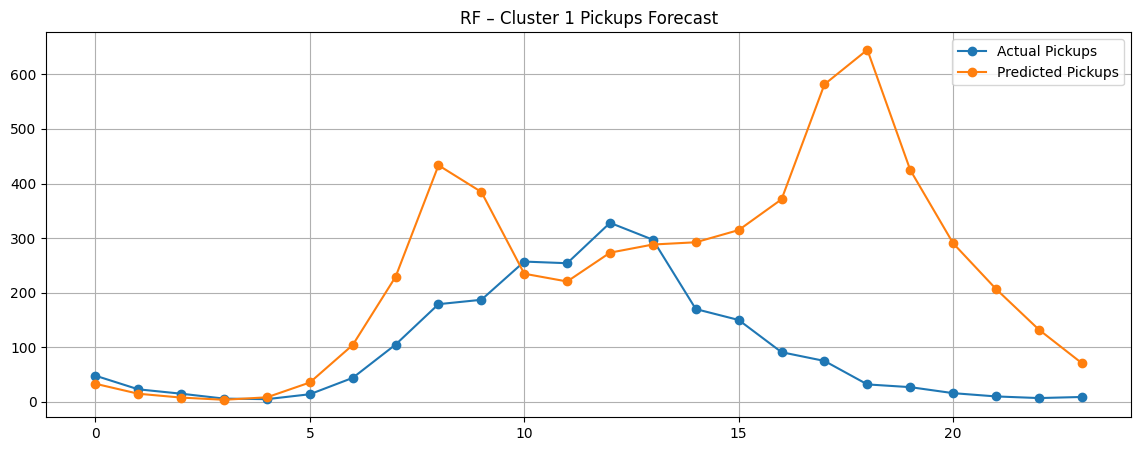

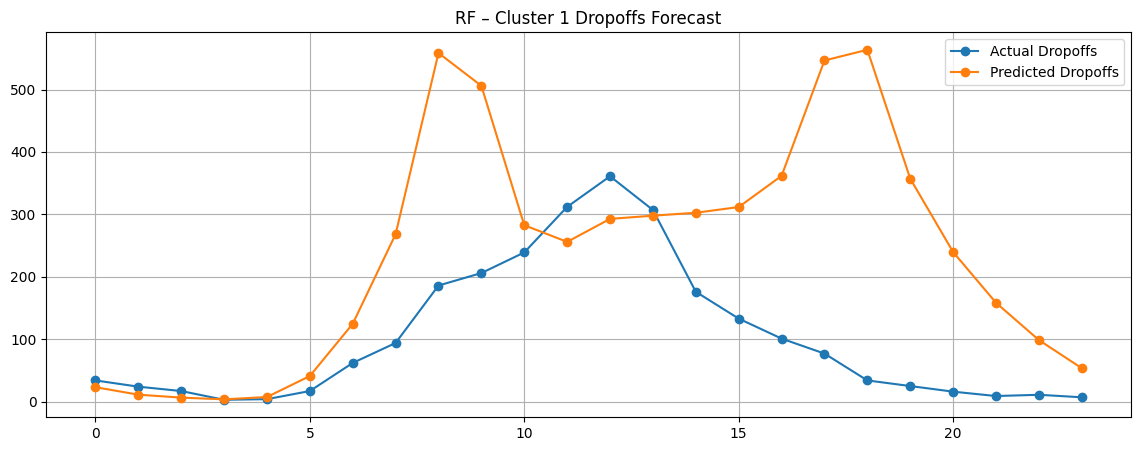

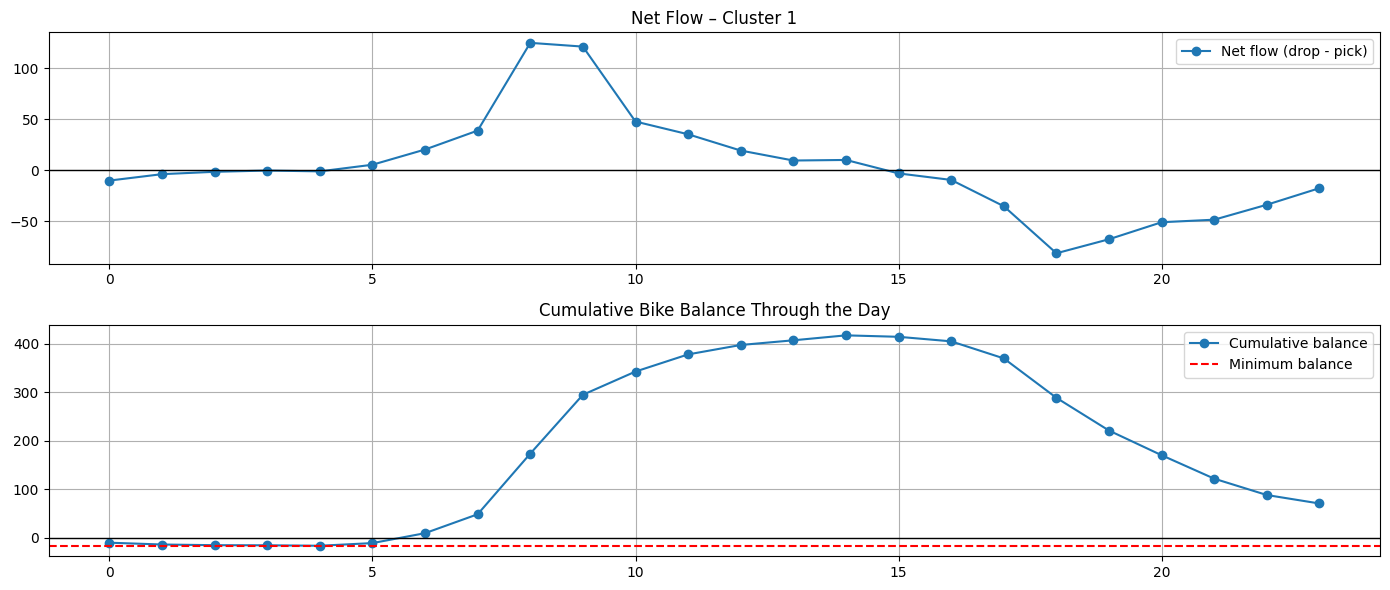


Cluster 1 requires 16 bikes at the start of next day.


>>> Task 1, 2, 3 with model: LR

Model: LR
Pickups  - MAE: 89.208, RMSE: 139.714
Dropoffs - MAE: 91.303, RMSE: 143.026


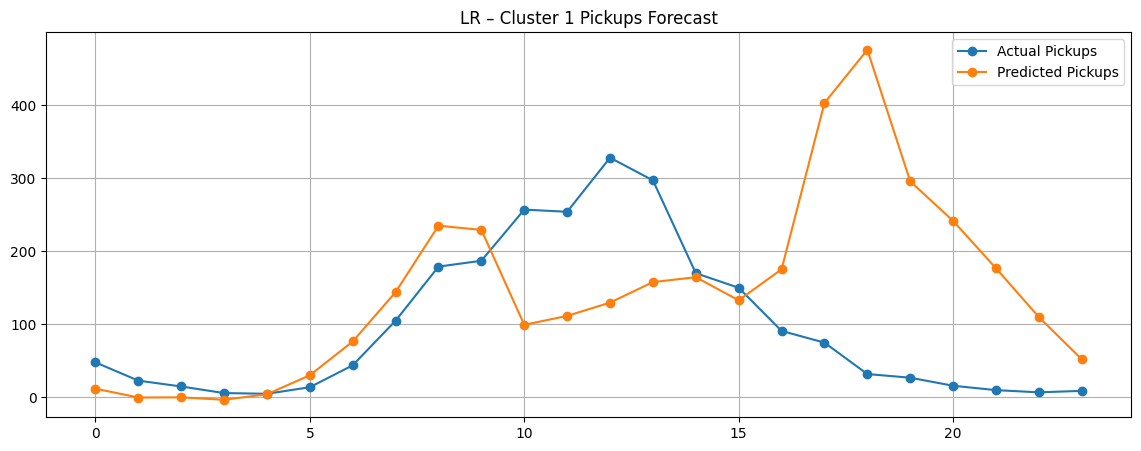

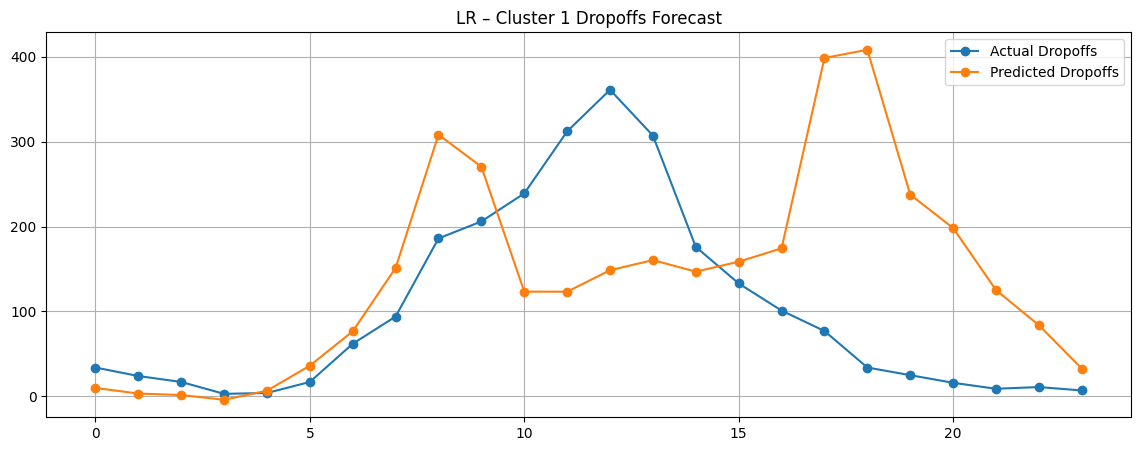

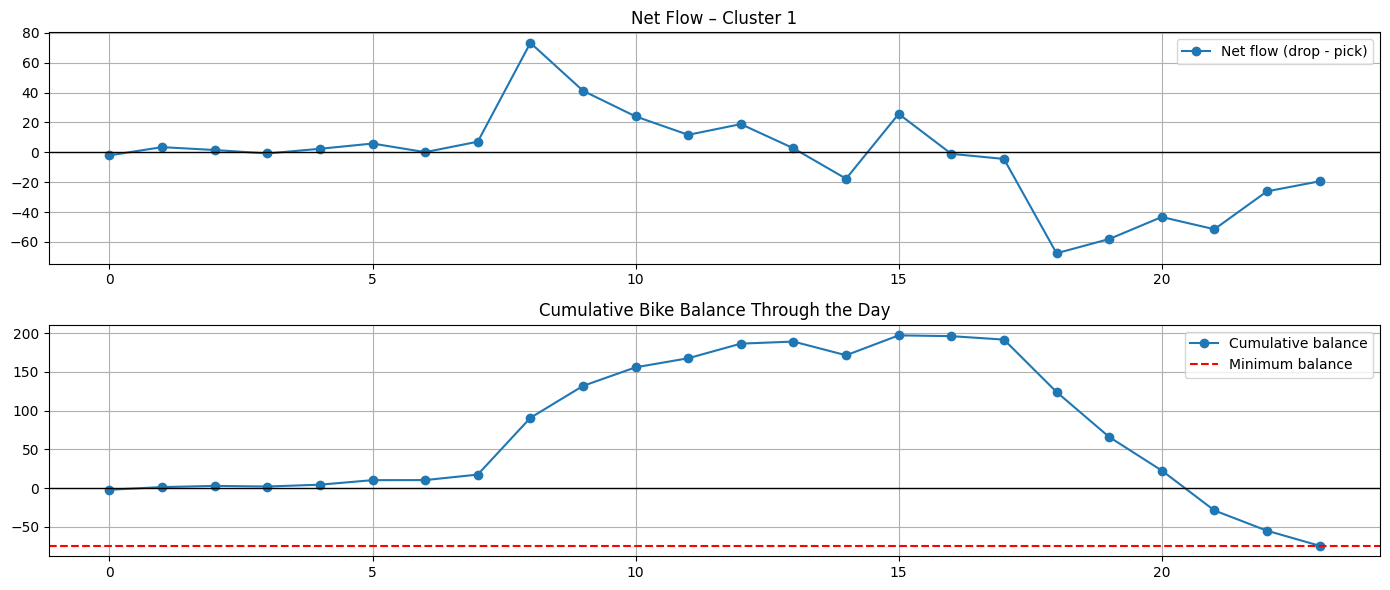


Cluster 1 requires 74 bikes at the start of next day.


>>> Task 1, 2, 3 with model: XGB

Model: XGB
Pickups  - MAE: 81.683, RMSE: 135.164
Dropoffs - MAE: 82.950, RMSE: 137.361


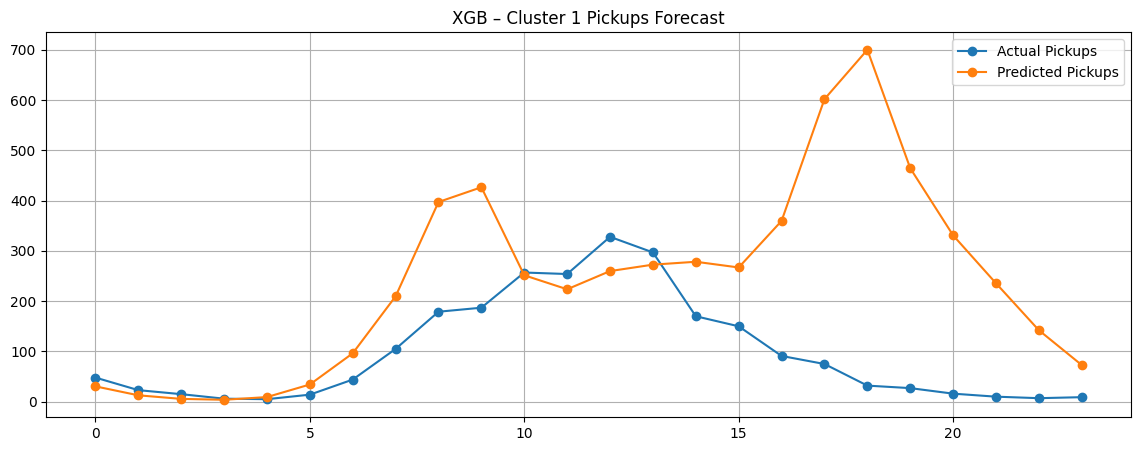

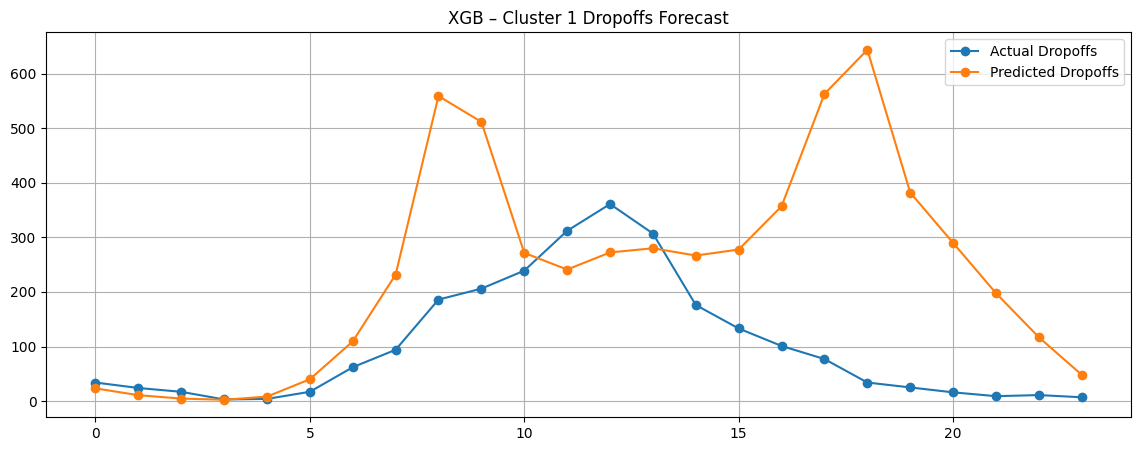

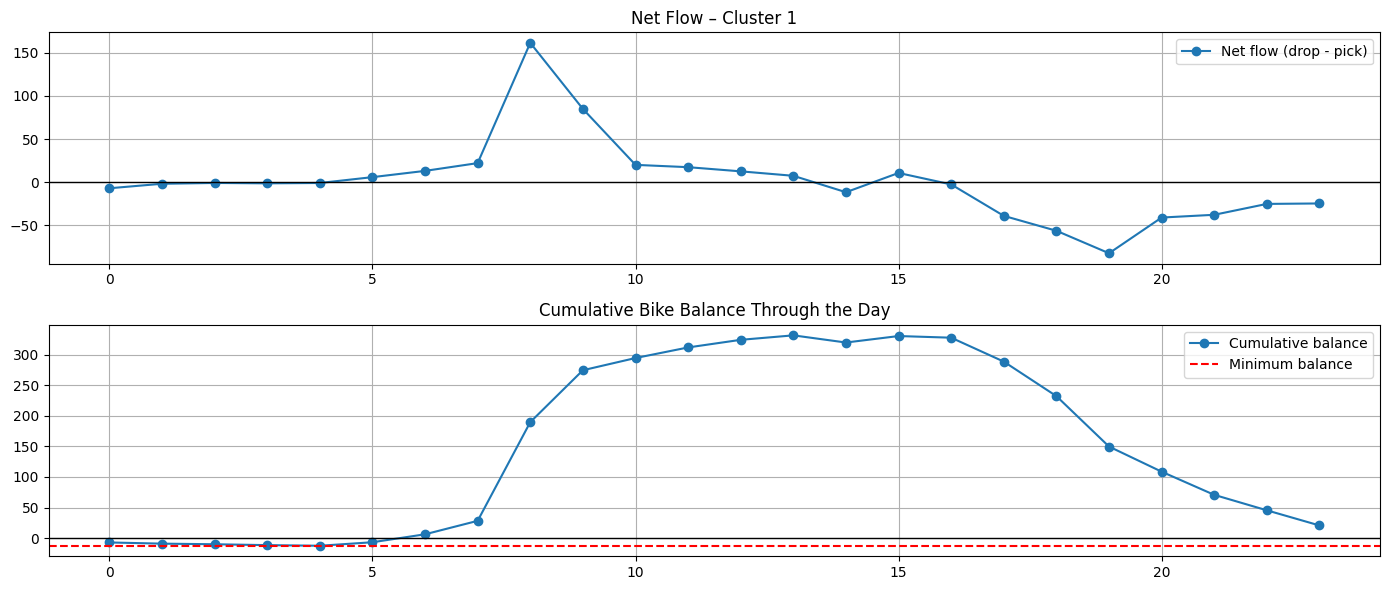


Cluster 1 requires 12 bikes at the start of next day.



#############################
###   CLUSTER 3   ###
#############################


  RUNNING ALL TASKS FOR CLUSTER 3


>>> Task 1, 2, 3 with model: RF

Model: RF
Pickups  - MAE: 28.973, RMSE: 45.538
Dropoffs - MAE: 28.598, RMSE: 45.226


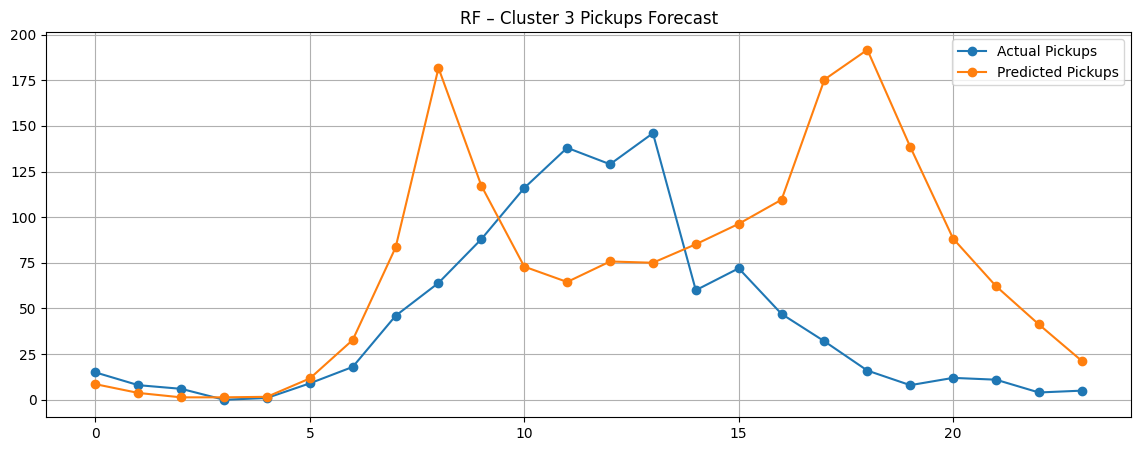

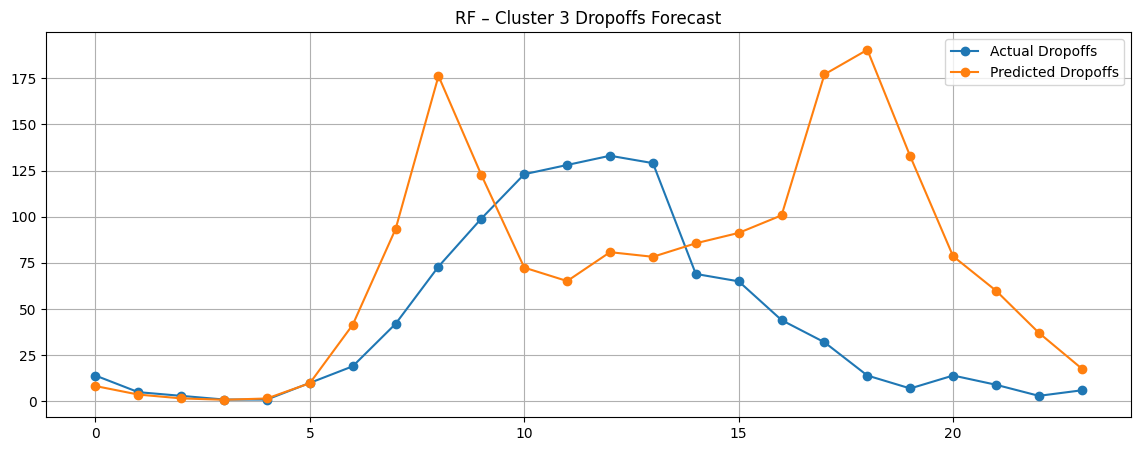

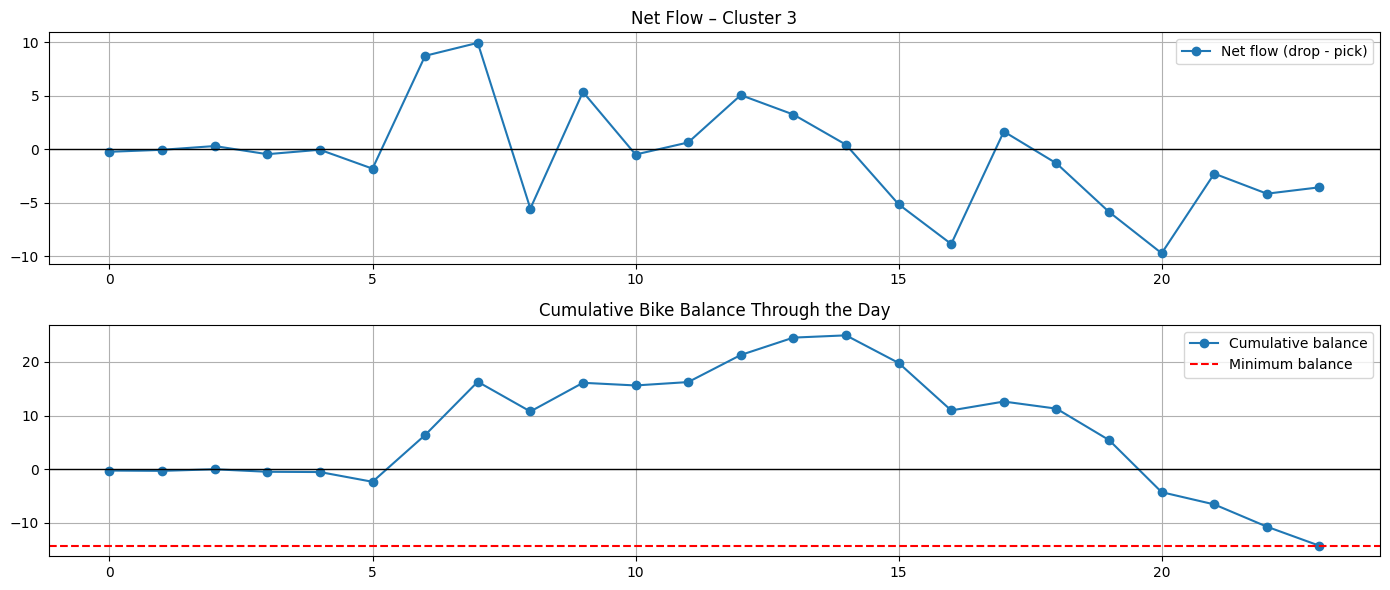


Cluster 3 requires 14 bikes at the start of next day.


>>> Task 1, 2, 3 with model: LR

Model: LR
Pickups  - MAE: 33.503, RMSE: 51.929
Dropoffs - MAE: 34.033, RMSE: 52.757


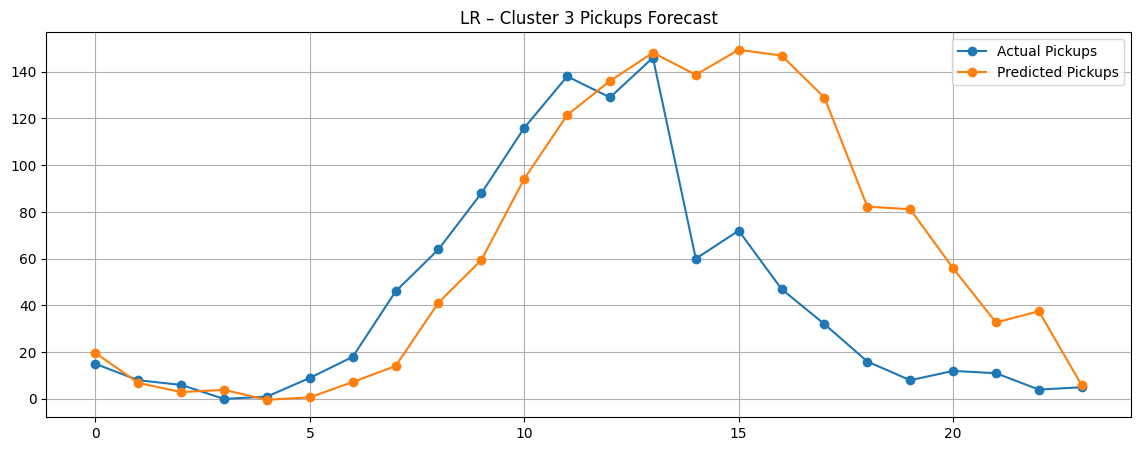

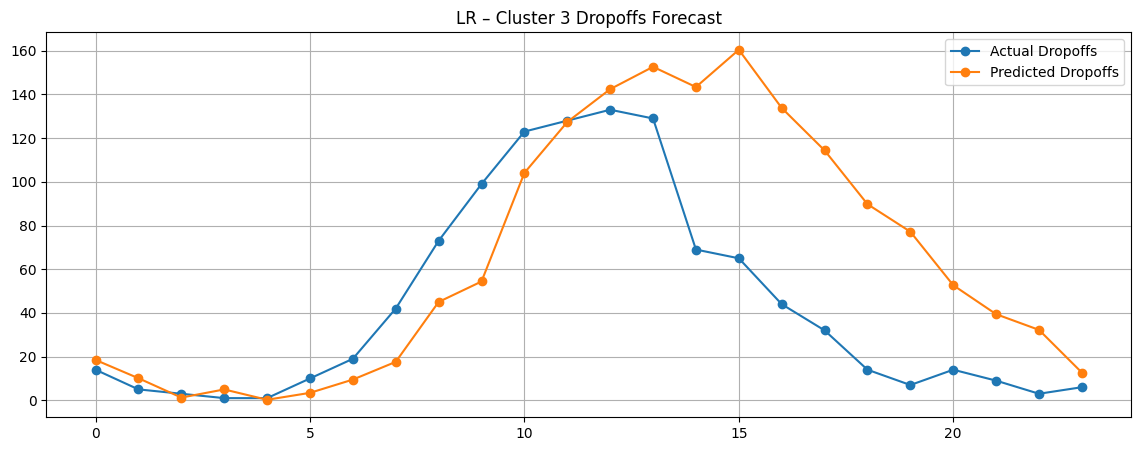

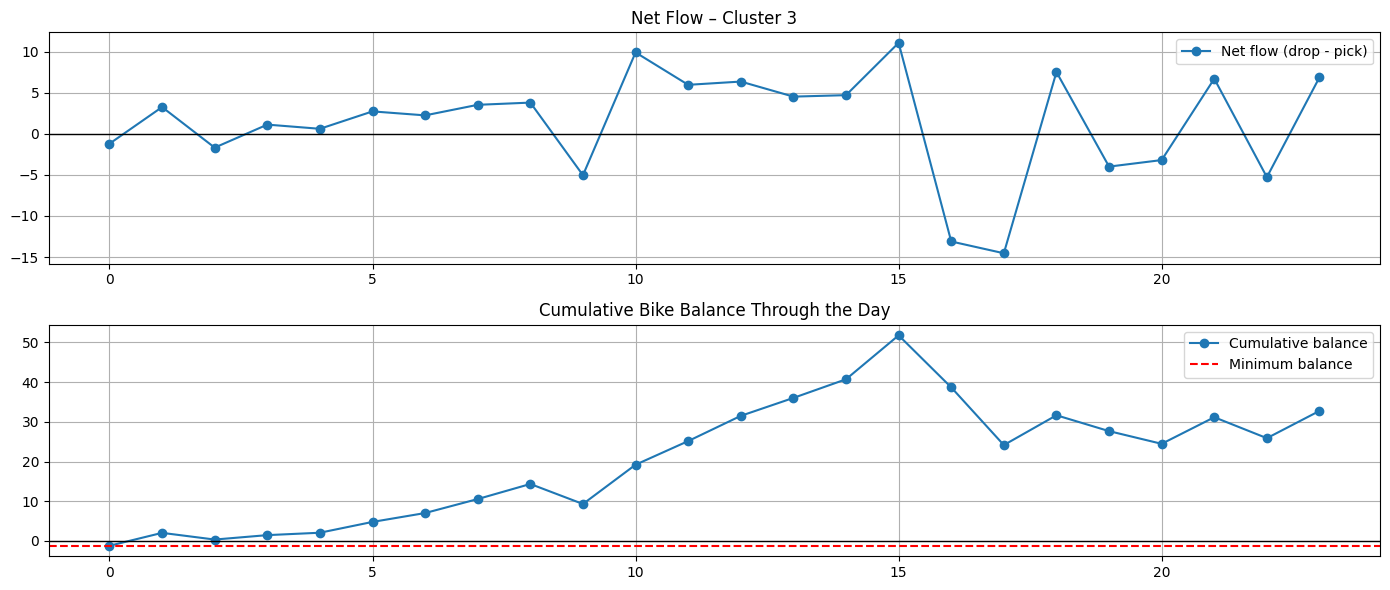


Cluster 3 requires 1 bikes at the start of next day.


>>> Task 1, 2, 3 with model: XGB

Model: XGB
Pickups  - MAE: 28.800, RMSE: 45.599
Dropoffs - MAE: 29.067, RMSE: 46.217


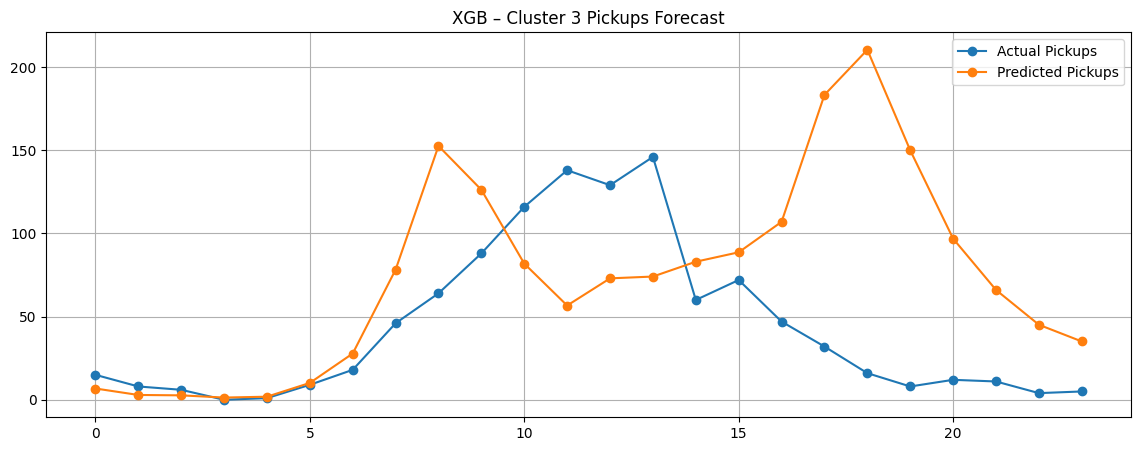

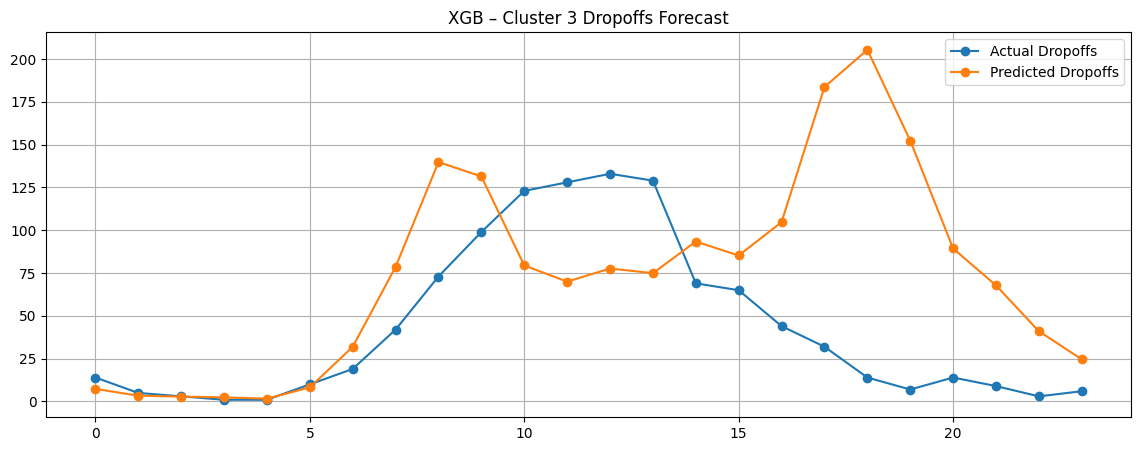

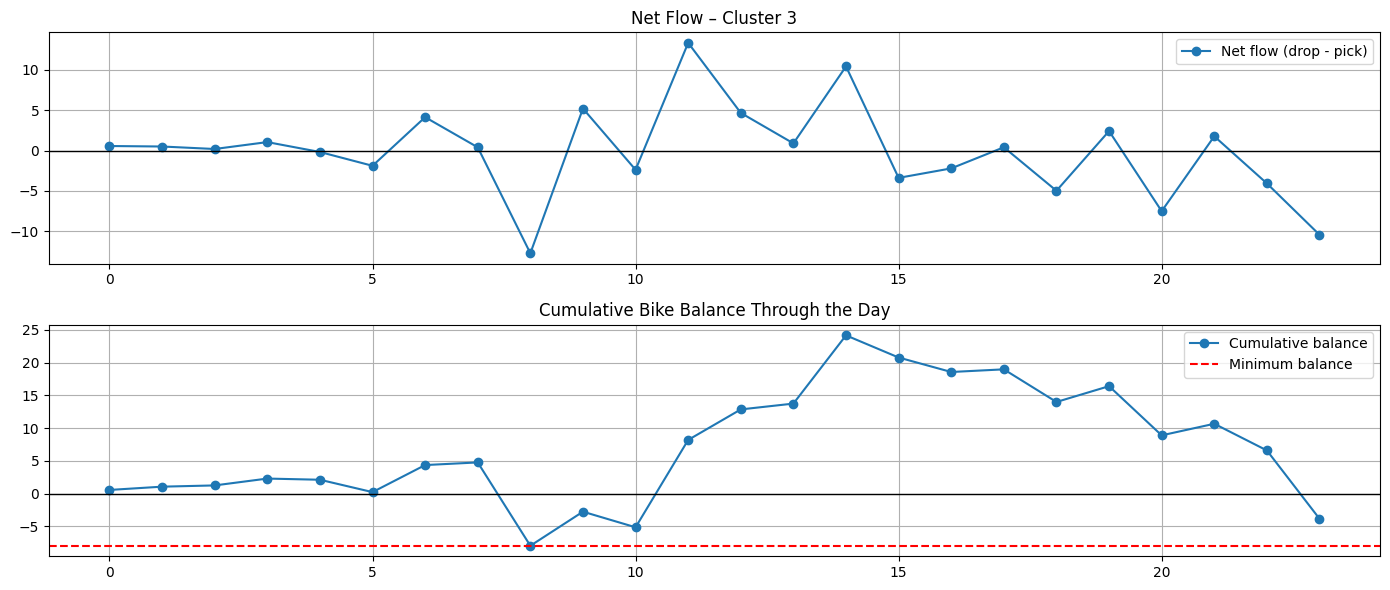


Cluster 3 requires 7 bikes at the start of next day.



#############################
###   CLUSTER 7   ###
#############################


  RUNNING ALL TASKS FOR CLUSTER 7


>>> Task 1, 2, 3 with model: RF

Model: RF
Pickups  - MAE: 60.199, RMSE: 106.395
Dropoffs - MAE: 60.836, RMSE: 102.762


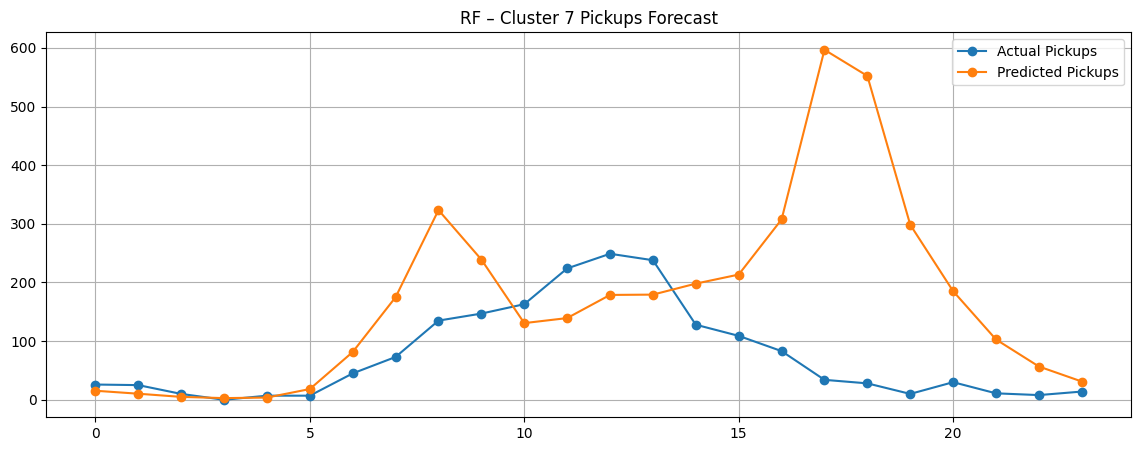

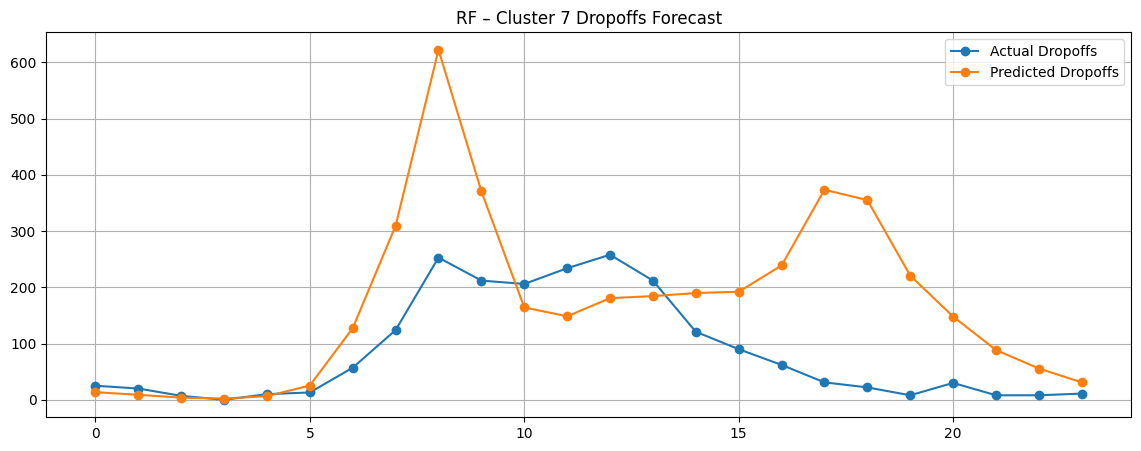

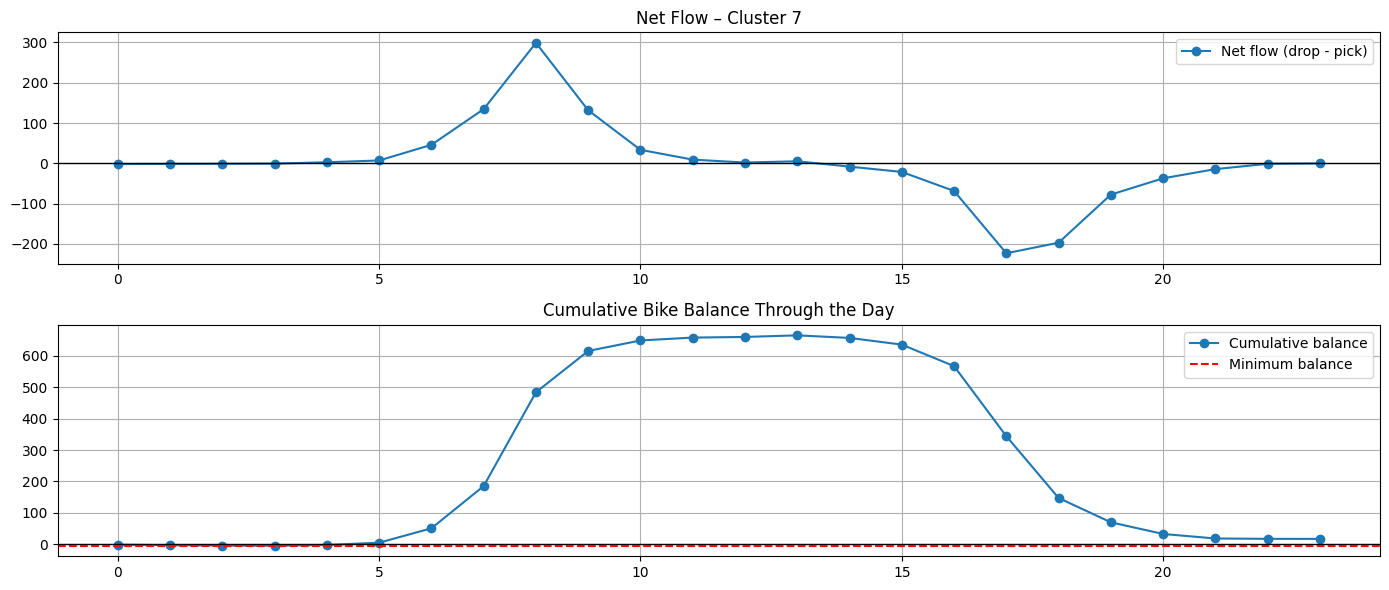


Cluster 7 requires 5 bikes at the start of next day.


>>> Task 1, 2, 3 with model: LR

Model: LR
Pickups  - MAE: 71.136, RMSE: 114.936
Dropoffs - MAE: 71.613, RMSE: 115.161


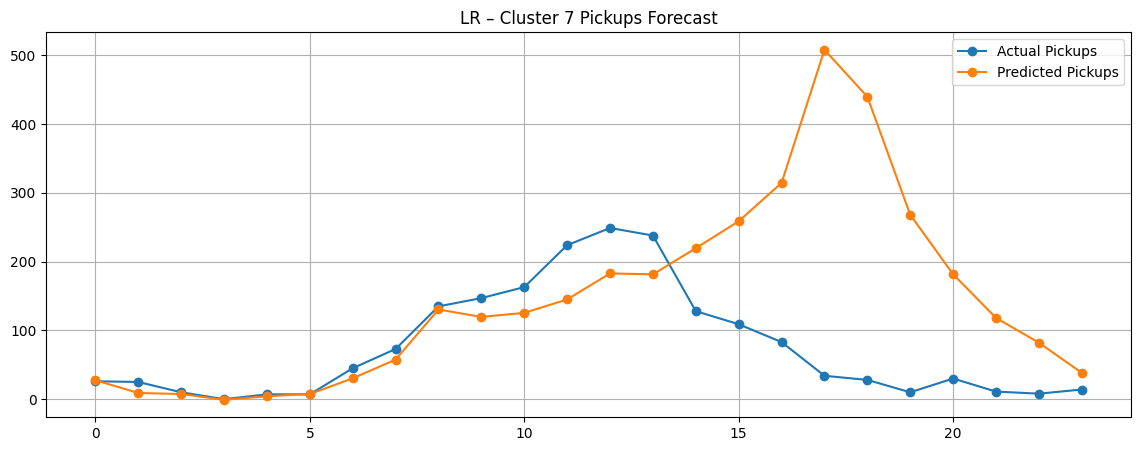

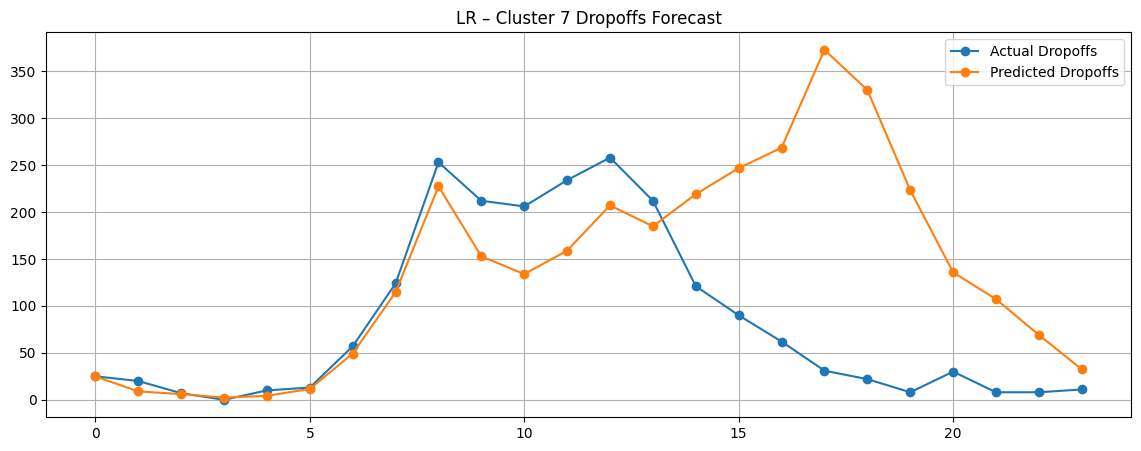

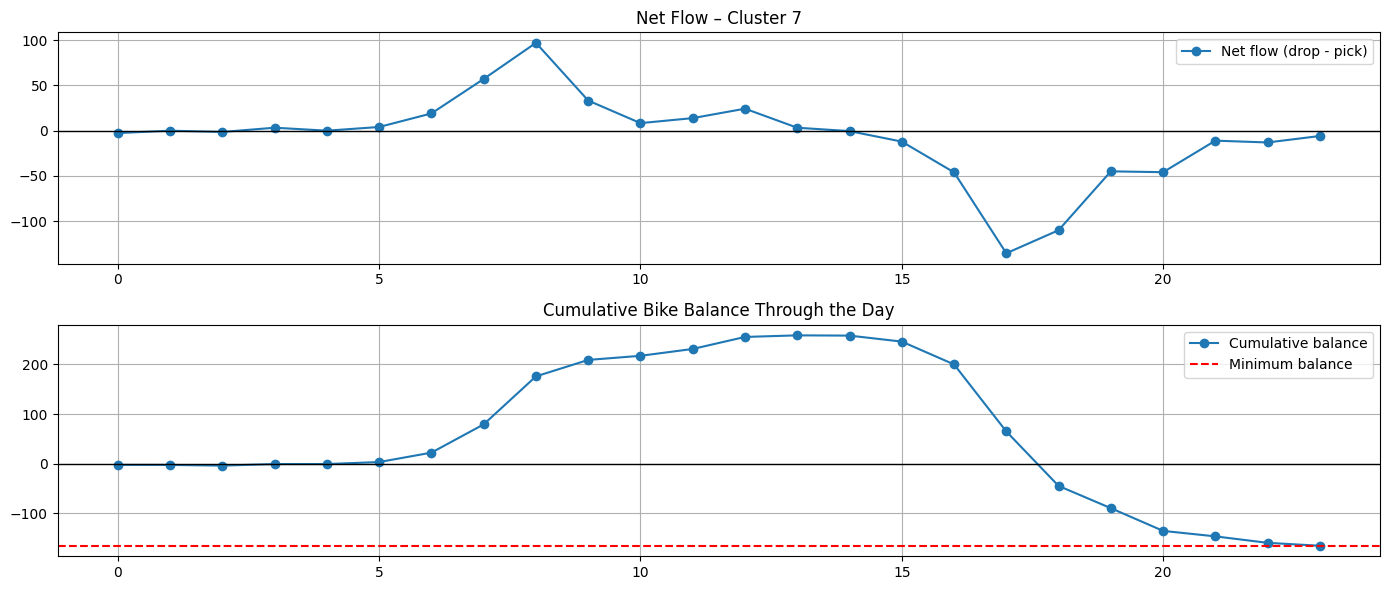


Cluster 7 requires 165 bikes at the start of next day.


>>> Task 1, 2, 3 with model: XGB

Model: XGB
Pickups  - MAE: 61.844, RMSE: 109.746
Dropoffs - MAE: 60.972, RMSE: 103.934


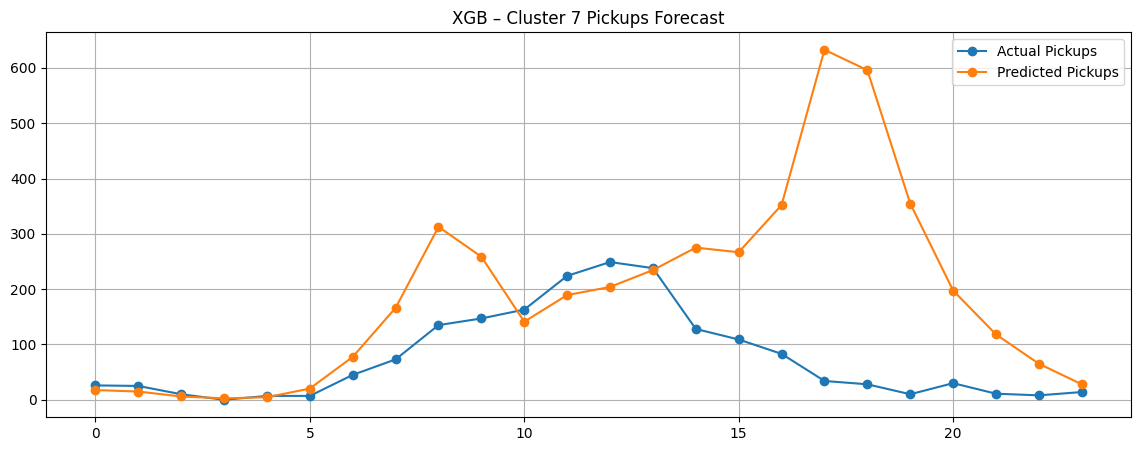

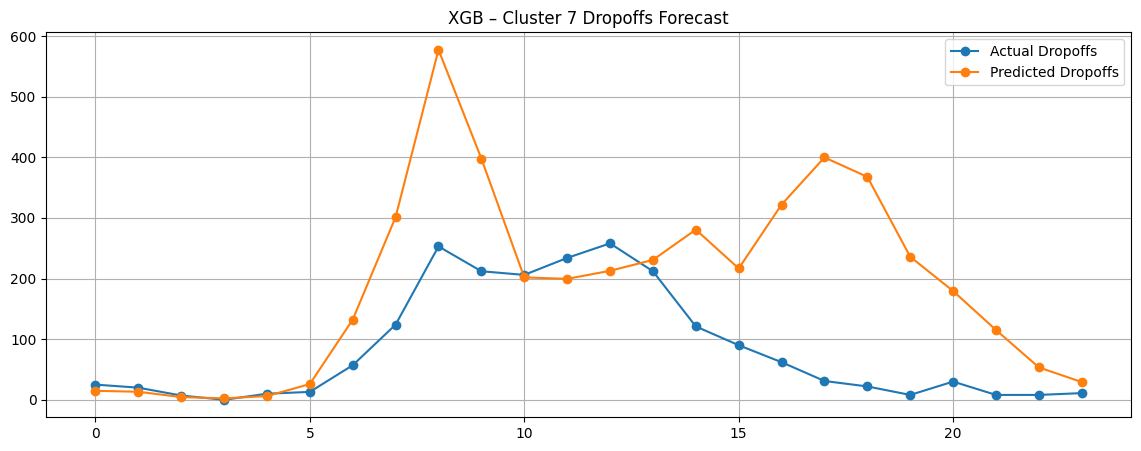

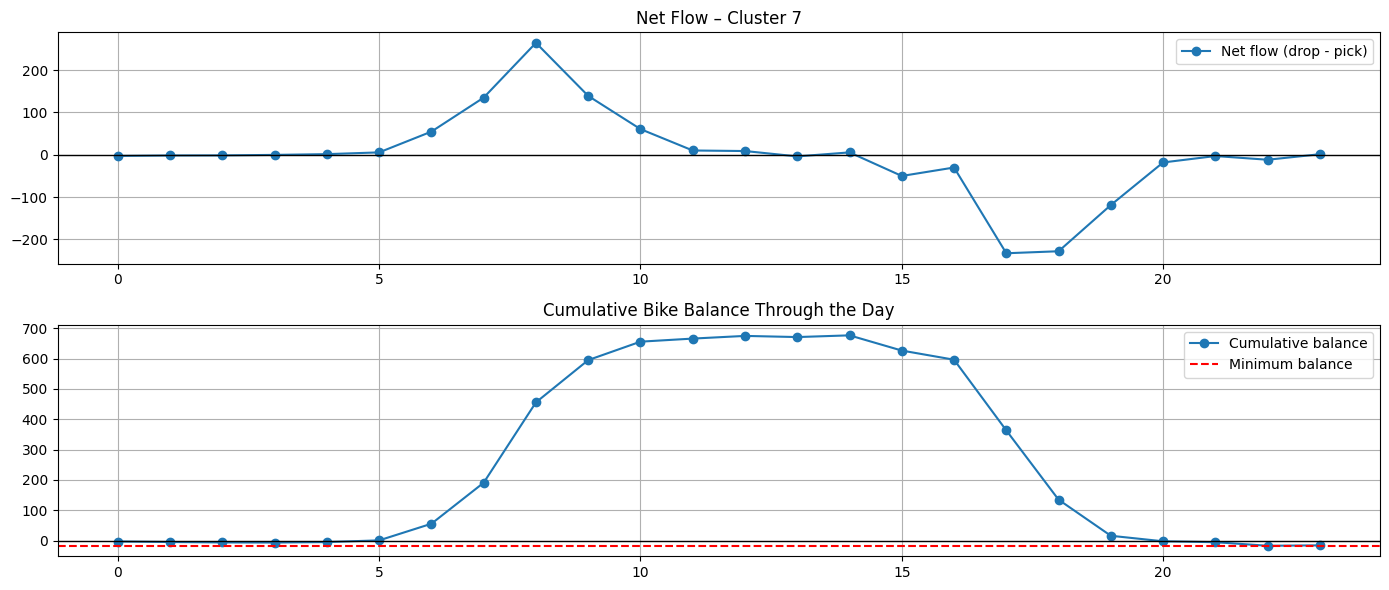


Cluster 7 requires 16 bikes at the start of next day.



In [46]:
results = run_all_clusters(highlight_clusters, models=["rf", "lr", "xgb"])

In [47]:
def results_to_df(results):
    rows = []
    for cid, data in results.items():
        for model, req in data["required_bikes"].items():
            rows.append({
                "cluster_id": cid,
                "model": model,
                "required_bikes": req
            })
    return pd.DataFrame(rows)

df_required = results_to_df(results)
df_required

,cluster_id,model,required_bikes
0,1,rf,16
1,1,lr,74
2,1,xgb,12
3,3,rf,14
4,3,lr,1
5,3,xgb,7
6,7,rf,5
7,7,lr,165
8,7,xgb,16


In [48]:
print("Κομπλε")

Κομπλε
